## Libraries & Packages

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [8]:
# from econml.dml import LinearDML, CausalForestDML
# from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter


## Load Data

In [9]:
# gervasio file_path
g_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"

In [10]:
# shruti


In [11]:
# fin
fin_path = "/Users/finbarrhodes/Documents/Github/ST498_CAPSTONE/FLASH/toShare"

### Reading CSVs; Time Column

In [12]:
control_file_name = "/controlePreConsolide.csv"
control_csv_path = fin_path + control_file_name
df_control = pd.read_csv(control_csv_path)
df_control = df_control.rename(columns={'Unnamed: 0': 'Time'})
df_control['Time'] = pd.to_datetime(df_control['Time'])

int_file_name = "/interventionPreConsolide.csv"
int_csv_path = fin_path + int_file_name
df_int = pd.read_csv(int_csv_path)
df_int = df_int.rename(columns={'Unnamed: 0': 'Time'})
df_int['Time'] = pd.to_datetime(df_int['Time'])

combined_groups = pd.concat([df_control, df_int])

In [13]:
len(df_control)

17314

In [14]:
abc = pd.Index([1, 2, 3, 4, 5, 6, 7])
de = pd.Index([1, 2, 3])

de.difference(abc)

Index([], dtype='int64')

### Missing FLASH Data

In [15]:
len(df_control['Time'].unique()) == len(df_control)
len(df_int['Time'].unique()) == len(df_int)

control_timestamps = pd.Index(df_control['Time'])
int_timestamps = pd.Index(df_int['Time'])

in_intervention_not_control = list(control_timestamps.difference(int_timestamps))
# 99 timestamps in intervention that are missing from control

in_control_not_intervention = list(int_timestamps.difference(control_timestamps))
# 156 timestamps in control that are missing from intervention 

# results in 57 row differential in df_control and df_int

# solution is to preprocess them separately and then combine them once we get IDs as rows and HH interval averages as columns

In [16]:
#type(in_control_not_intervention.to_datetime())
#in_control_not_intervention = in_control_not_intervention.to_pydatetime()

in_control_not_intervention = [i.to_pydatetime() for i in in_control_not_intervention]
type(in_control_not_intervention)
# type(in_control_not_intervention[0].to_pydatetime())

in_control_not_intervention = pd.to_datetime(in_control_not_intervention)



In [17]:
type(in_control_not_intervention)

pandas.core.indexes.datetimes.DatetimeIndex

#### Plotting Distributions

In Control, Not Intervention

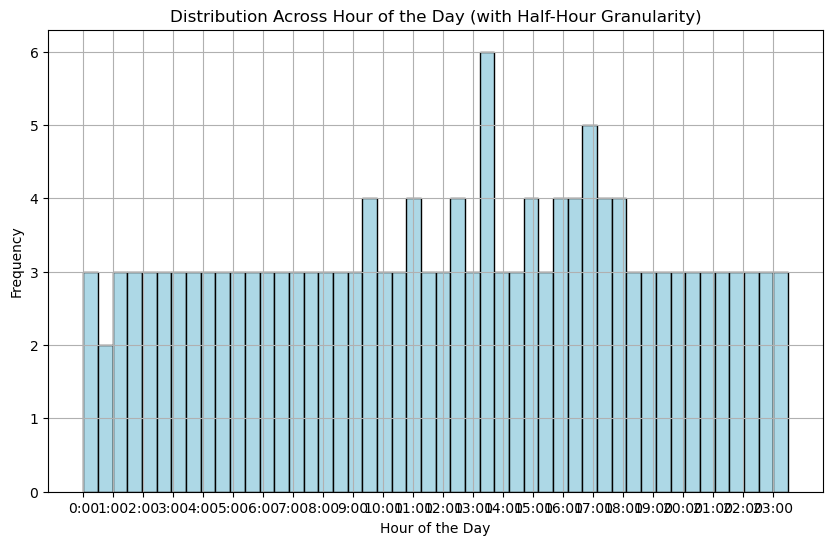

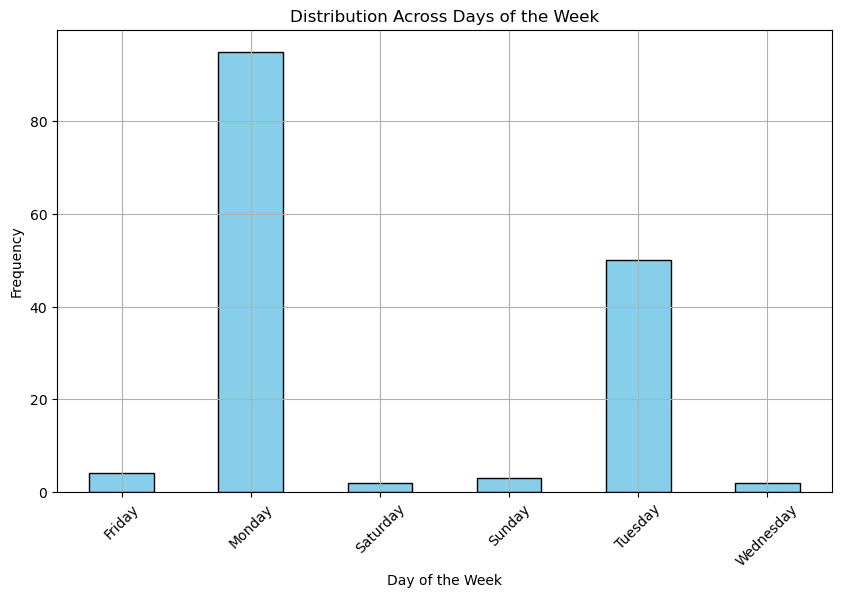

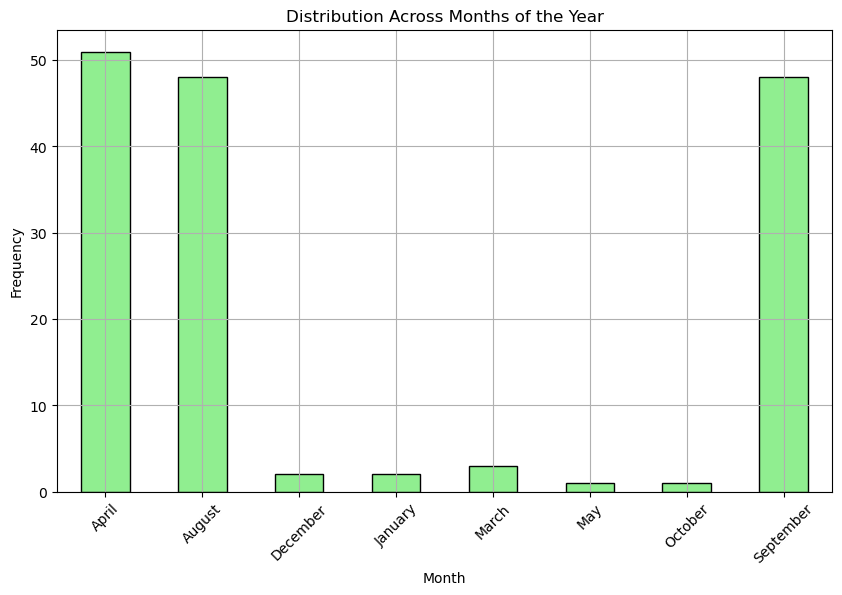

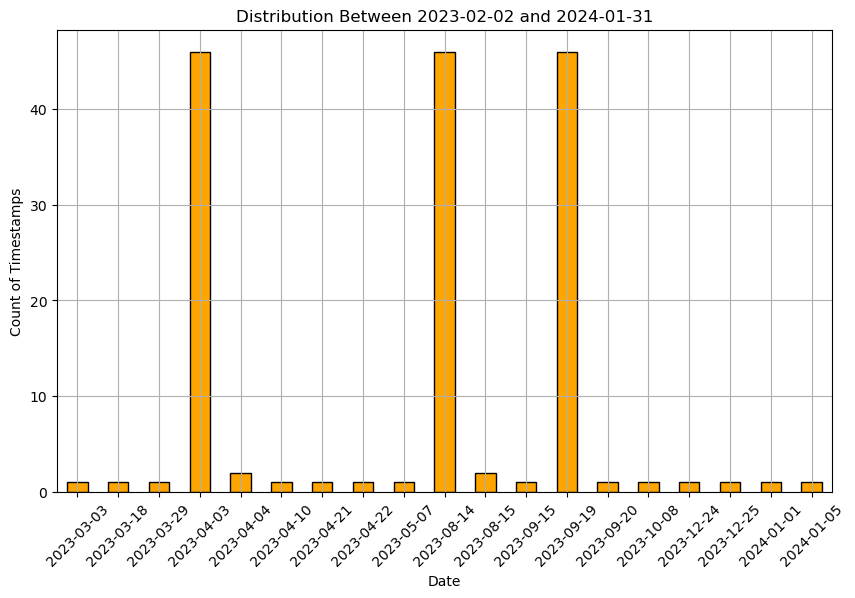

In [18]:
df = pd.DataFrame({'value': range(156)}, index=in_control_not_intervention)

# 1. Distribution Across Hour of the Day (Half-Hour Granularity)
hours_of_day = df.index.hour + df.index.minute / 60  # Hour with minute fraction

# Plot the histogram for hours of the day (half-hour granularity)
plt.figure(figsize=(10, 6))
plt.hist(hours_of_day, bins=48, edgecolor='black', color='lightblue')  # 48 bins for half-hour intervals
plt.title("Distribution Across Hour of the Day (with Half-Hour Granularity)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(24), [f'{h}:00' for h in range(24)])  # Label x-axis with hourly values
plt.grid(True)
plt.show()

# 2. Distribution Across Days of the Week
days_of_week = df.index.day_name()

# Plot the histogram for days of the week
plt.figure(figsize=(10, 6))
days_of_week.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Distribution Across Months of the Year
months_of_year = df.index.month_name()

# Plot the histogram for months of the year
plt.figure(figsize=(10, 6))
months_of_year.value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution Across Months of the Year")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 4. Distribution Within a Predefined Date Range
# Example predefined range:
start_date = pd.to_datetime('2023-02-02')
end_date = pd.to_datetime('2024-01-31')

# Filter timestamps within the specified range (using the DatetimeIndex)
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Extract just the date part (ignoring the time part) for grouping by day
filtered_df['date'] = filtered_df.index.date

# Count the occurrences of each date within the predefined range
date_counts = filtered_df['date'].value_counts().sort_index()

# Plot the histogram for the predefined date range (across entire days)
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title(f"Distribution Between {start_date.date()} and {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Count of Timestamps")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In Intervention, Not Control

In [19]:
months_of_year

Index(['March', 'March', 'March', 'April', 'April', 'April', 'April', 'April',
       'April', 'April',
       ...
       'September', 'September', 'September', 'September', 'September',
       'October', 'December', 'December', 'January', 'January'],
      dtype='object', length=156)

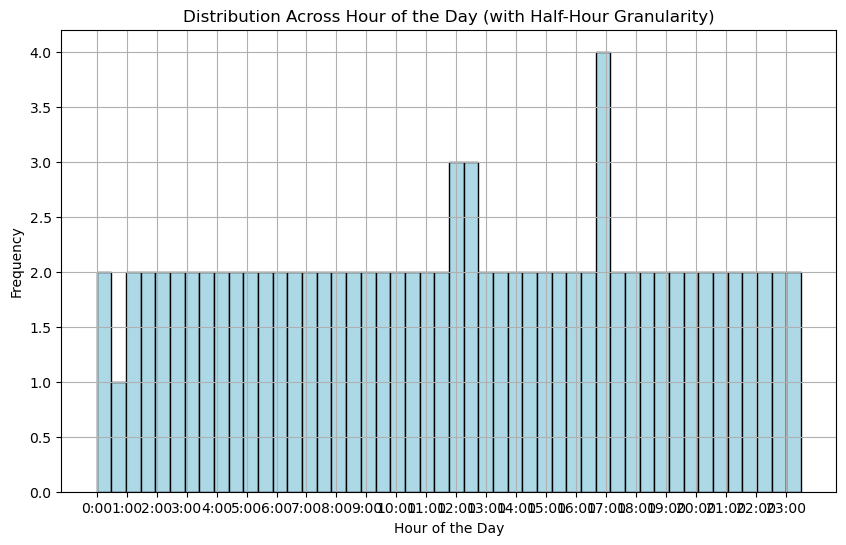

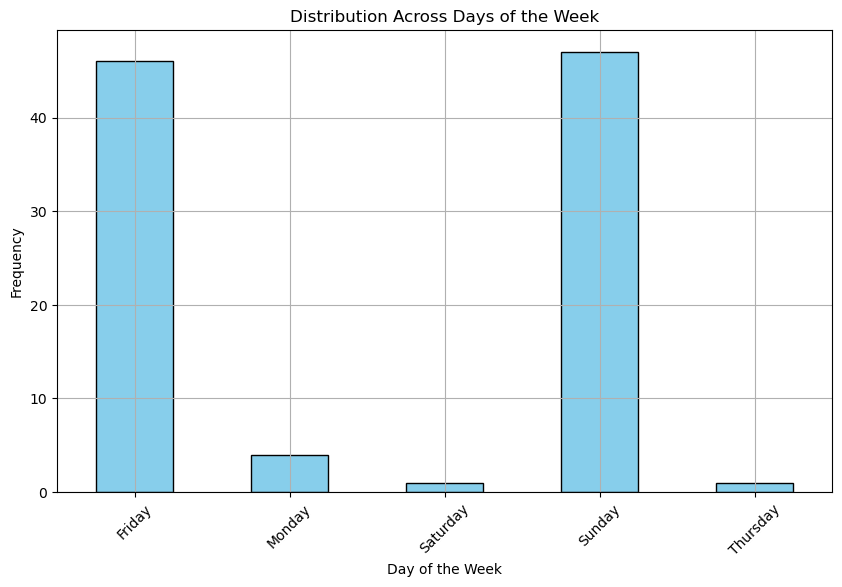

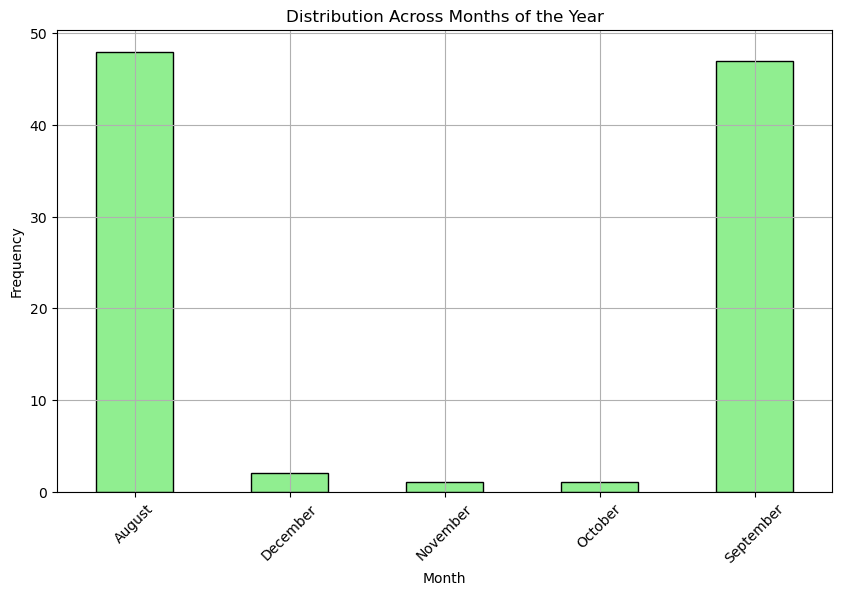

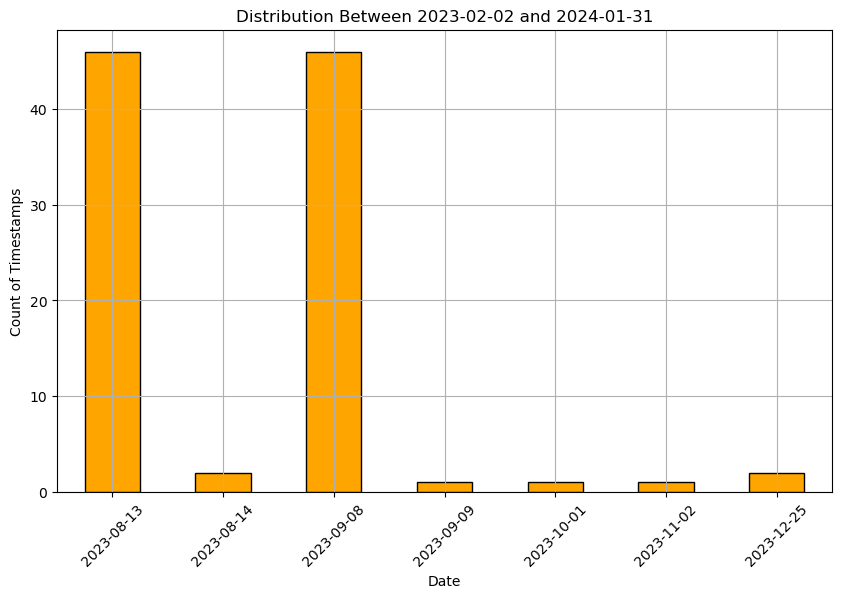

In [20]:
df = pd.DataFrame({'value': range(99)}, index=in_intervention_not_control)

# 1. Distribution Across Hour of the Day (Half-Hour Granularity)
hours_of_day = df.index.hour + df.index.minute / 60  # Hour with minute fraction

# Plot the histogram for hours of the day (half-hour granularity)
plt.figure(figsize=(10, 6))
plt.hist(hours_of_day, bins=48, edgecolor='black', color='lightblue')  # 48 bins for half-hour intervals
plt.title("Distribution Across Hour of the Day (with Half-Hour Granularity)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(24), [f'{h}:00' for h in range(24)])  # Label x-axis with hourly values
plt.grid(True)
plt.show()

# 2. Distribution Across Days of the Week
days_of_week = df.index.day_name()

# Plot the histogram for days of the week
plt.figure(figsize=(10, 6))
days_of_week.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Distribution Across Months of the Year
months_of_year = df.index.month_name()

# Plot the histogram for months of the year
plt.figure(figsize=(10, 6))
months_of_year.value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution Across Months of the Year")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 4. Distribution Within a Predefined Date Range
# Example predefined range:
start_date = pd.to_datetime('2023-02-02')
end_date = pd.to_datetime('2024-01-31')

# Filter timestamps within the specified range (using the DatetimeIndex)
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Extract just the date part (ignoring the time part) for grouping by day
filtered_df['date'] = filtered_df.index.date

# Count the occurrences of each date within the predefined range
date_counts = filtered_df['date'].value_counts().sort_index()

# Plot the histogram for the predefined date range (across entire days)
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title(f"Distribution Between {start_date.date()} and {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Count of Timestamps")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


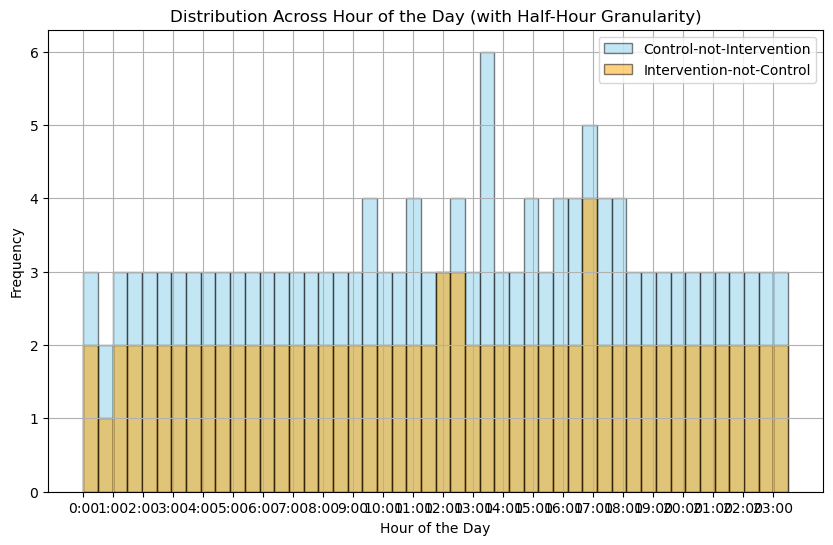

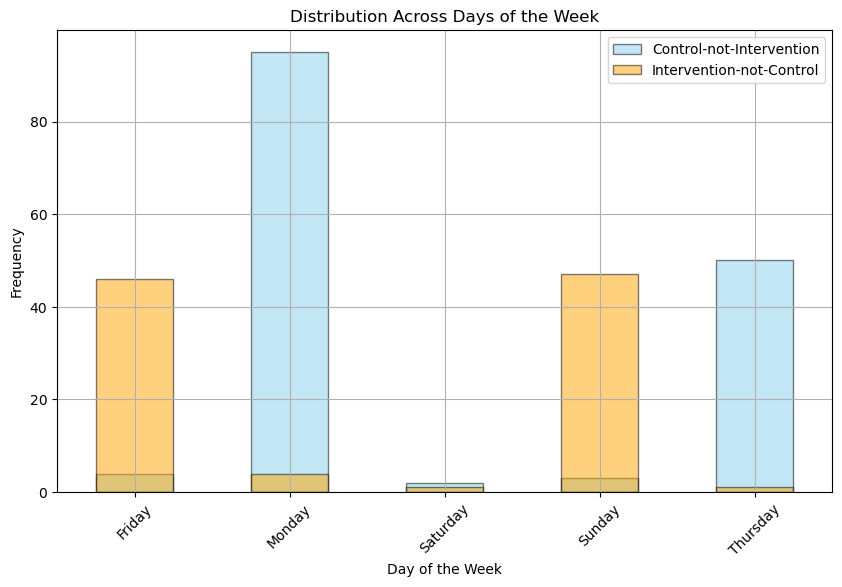

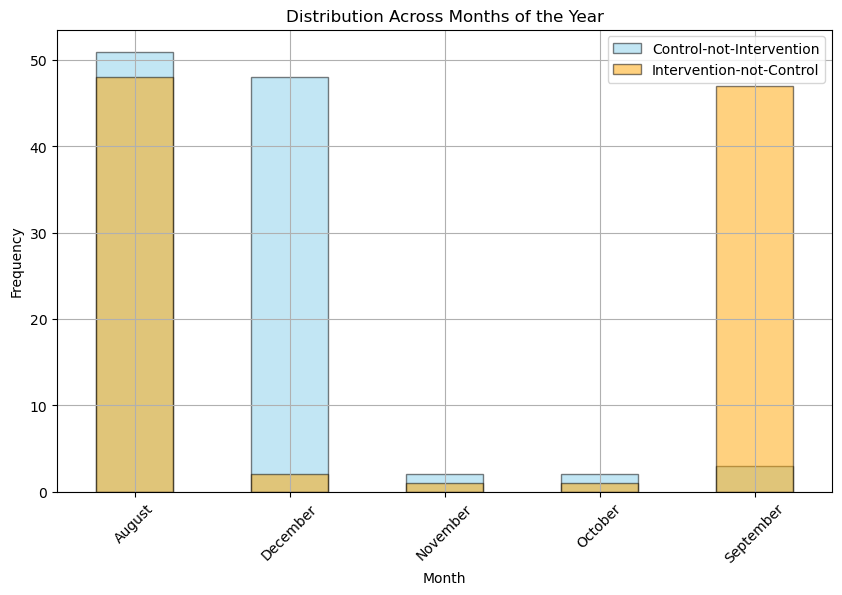

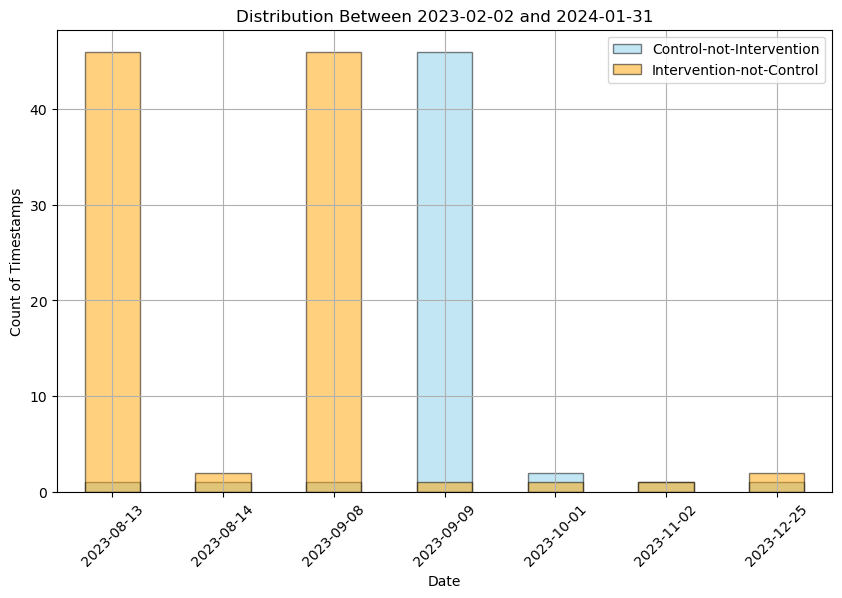

In [21]:

# Creating DataFrames with a DatetimeIndex for both sets
df1 = pd.DataFrame({'value': range(156)}, index=in_control_not_intervention)
df2 = pd.DataFrame({'value': range(99)}, index=in_intervention_not_control)

# 1. Distribution Across Hour of the Day (Half-Hour Granularity)
hours_of_day_1 = df1.index.hour + df1.index.minute / 60  # Hour with minute fraction
hours_of_day_2 = df2.index.hour + df2.index.minute / 60  # Hour with minute fraction

# Plot the histogram for hours of the day (half-hour granularity)
plt.figure(figsize=(10, 6))
plt.hist(hours_of_day_1, bins=48, edgecolor='black', color='skyblue', alpha=0.5, label='Control-not-Intervention')
plt.hist(hours_of_day_2, bins=48, edgecolor='black', color='orange', alpha=0.5, label='Intervention-not-Control')
plt.title("Distribution Across Hour of the Day (with Half-Hour Granularity)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(24), [f'{h}:00' for h in range(24)])  # Label x-axis with hourly values
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribution Across Days of the Week
days_of_week_1 = df1.index.day_name()
days_of_week_2 = df2.index.day_name()

# Plot the histogram for days of the week
plt.figure(figsize=(10, 6))
days_of_week_1.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.5, label='Control-not-Intervention')
days_of_week_2.value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black', alpha=0.5, label='Intervention-not-Control')
plt.title("Distribution Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 3. Distribution Across Months of the Year
months_of_year_1 = df1.index.month_name()
months_of_year_2 = df2.index.month_name()

# Plot the histogram for months of the year
plt.figure(figsize=(10, 6))
months_of_year_1.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.5, label='Control-not-Intervention')
months_of_year_2.value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black', alpha=0.5, label='Intervention-not-Control')
plt.title("Distribution Across Months of the Year")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 4. Distribution Within a Predefined Date Range (Across Entire Days)
# Example predefined range:
start_date = pd.to_datetime('2023-02-02')
end_date = pd.to_datetime('2024-01-31')

# Filter timestamps within the specified range (using the DatetimeIndex)
filtered_df1 = df1[(df1.index >= start_date) & (df1.index <= end_date)]
filtered_df2 = df2[(df2.index >= start_date) & (df2.index <= end_date)]

# Extract just the date part (ignoring the time part) for grouping by day
filtered_df1['date'] = filtered_df1.index.date
filtered_df2['date'] = filtered_df2.index.date

# Count the occurrences of each date within the predefined range
date_counts_1 = filtered_df1['date'].value_counts().sort_index()
date_counts_2 = filtered_df2['date'].value_counts().sort_index()

# Plot the histogram for the predefined date range (across entire days)
plt.figure(figsize=(10, 6))
date_counts_1.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.5, label='Control-not-Intervention')
date_counts_2.plot(kind='bar', color='orange', edgecolor='black', alpha=0.5, label='Intervention-not-Control')
plt.title(f"Distribution Between {start_date.date()} and {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Count of Timestamps")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


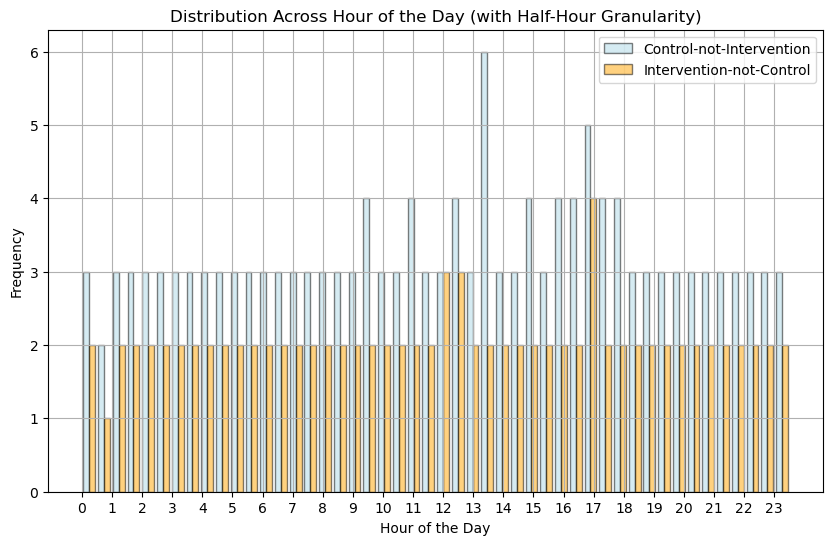

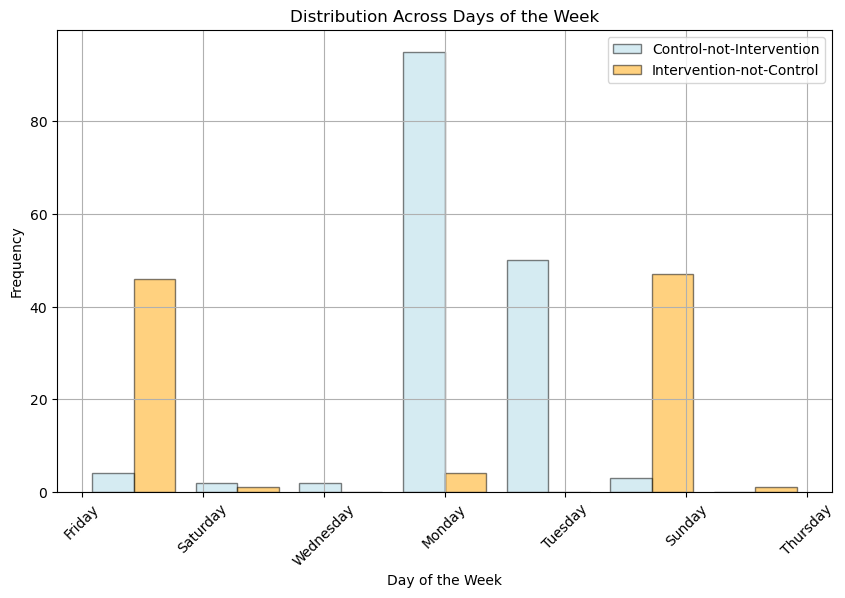

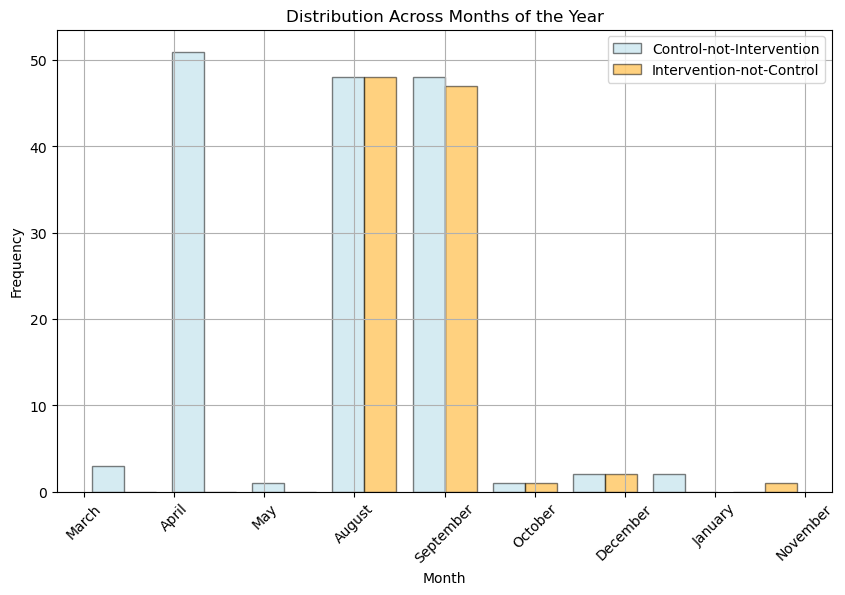

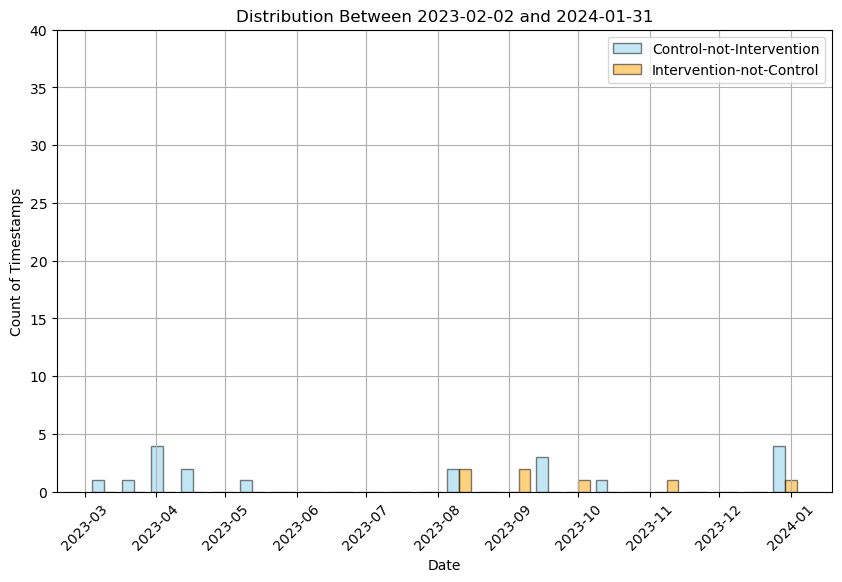

In [22]:
# Creating DataFrames with a DatetimeIndex for both sets
df1 = pd.DataFrame({'value': range(156)}, index=in_control_not_intervention)
df2 = pd.DataFrame({'value': range(99)}, index=in_intervention_not_control)

# 1. Distribution Across Hour of the Day (Half-Hour Granularity)
hours_of_day_1 = df1.index.hour + df1.index.minute / 60  # Hour with minute fraction
hours_of_day_2 = df2.index.hour + df2.index.minute / 60  # Hour with minute fraction

# Get all unique values for hours across both sets
all_hours = pd.concat([pd.Series(hours_of_day_1), pd.Series(hours_of_day_2)]).unique()

# Plot the histogram for hours of the day (half-hour granularity)
plt.figure(figsize=(10, 6))
plt.hist([hours_of_day_1, hours_of_day_2], bins=len(all_hours), edgecolor='black', color=['lightblue', 'orange'], alpha=0.5, label=['Control-not-Intervention', 'Intervention-not-Control'])
plt.title("Distribution Across Hour of the Day (with Half-Hour Granularity)")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.xticks(range(24))  # Label x-axis with hourly values
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribution Across Days of the Week
days_of_week_1 = df1.index.day_name()
days_of_week_2 = df2.index.day_name()

# Get all unique days across both sets
all_days = pd.concat([pd.Series(days_of_week_1), pd.Series(days_of_week_2)]).unique()

# Plot the histogram for days of the week
plt.figure(figsize=(10, 6))
plt.hist([days_of_week_1, days_of_week_2], bins=len(all_days), edgecolor='black', color=['lightblue', 'orange'], alpha=0.5, label=['Control-not-Intervention', 'Intervention-not-Control'])
plt.title("Distribution Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 3. Distribution Across Months of the Year
months_of_year_1 = df1.index.month_name()
months_of_year_2 = df2.index.month_name()

# Get all unique months across both sets
all_months = pd.concat([pd.Series(months_of_year_1), pd.Series(months_of_year_2)]).unique()

# Plot the histogram for months of the year
plt.figure(figsize=(10, 6))
plt.hist([months_of_year_1, months_of_year_2], bins=len(all_months), edgecolor='black', color=['lightblue', 'orange'], alpha=0.5, label=['Control-not-Intervention', 'Intervention-not-Control'])
plt.title("Distribution Across Months of the Year")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 4. Distribution Within a Predefined Date Range (Across Entire Days)
# Example predefined range:
start_date = pd.to_datetime('2023-02-02')
end_date = pd.to_datetime('2024-01-31')

# Filter timestamps within the specified range (using the DatetimeIndex)
filtered_df1 = df1[(df1.index >= start_date) & (df1.index <= end_date)]
filtered_df2 = df2[(df2.index >= start_date) & (df2.index <= end_date)]

# Extract just the date part (ignoring the time part) for grouping by day
filtered_df1['date'] = filtered_df1.index.date
filtered_df2['date'] = filtered_df2.index.date

# Get all unique dates across both sets
all_dates = pd.concat([pd.Series(filtered_df1['date']), pd.Series(filtered_df2['date'])]).unique()

# Count the occurrences of each date within the predefined range
date_counts_1 = filtered_df1['date'].value_counts().sort_index()
date_counts_2 = filtered_df2['date'].value_counts().sort_index()

# Plot the histogram for the predefined date range (across entire days)
plt.figure(figsize=(10, 6))
plt.hist([date_counts_1.index, date_counts_2.index], bins=len(all_dates), edgecolor='black', color=['skyblue', 'orange'], alpha=0.5, label=['Control-not-Intervention', 'Intervention-not-Control'])
plt.title(f"Distribution Between {start_date.date()} and {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Count of Timestamps")
plt.xticks(rotation=45)
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.show()


In [23]:
filtered_df1['date'].value_counts()


date
2023-08-14    46
2023-04-03    46
2023-09-19    46
2023-04-04     2
2023-08-15     2
2023-09-15     1
2024-01-01     1
2023-12-25     1
2023-12-24     1
2023-10-08     1
2023-09-20     1
2023-03-03     1
2023-03-18     1
2023-05-07     1
2023-04-22     1
2023-04-21     1
2023-04-10     1
2023-03-29     1
2024-01-05     1
Name: count, dtype: int64

Socioeconomic Data

In [24]:
socio_file = r"/socioEcodata.csv"
socio_csv_path = fin_path + socio_file
df_socio = pd.read_csv(socio_csv_path)

## Generic Data comments:
1. Socioeconomic info for 1138 IDs with a total of 18 columns
2. ControlConsolide has 11420 half-hour readings for 506 IDs
3. Socioeconomic has no repeated features nor IDs
4. In ControlConsolide, 487 / 506 IDs dhave socioeconomic features
5. The timeframe of ControlConsolide is 2024-04-01 to 2024-12-31


In [25]:
print("Pre-Control Data:", df_control.shape)
print("Pre-Intervention Data:", df_int.shape)
print("Socioeconomic Data:", df_socio.shape)

Pre-Control Data: (17314, 321)
Pre-Intervention Data: (17371, 388)
Socioeconomic Data: (1138, 18)


In [26]:
df_socio.columns

Index(['HASH_KEY', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'ESTIMATED_CONSUMPTION_ELEC_DAY',
       'ESTIMATED_CONSUMPTION_ELEC_NIGHT', 'ESTIMATED_CONSUMPTION_TOTAL'],
      dtype='object')

In [27]:
df_socio.head()

,HASH_KEY,AGE_GROUP,INCOME_CATEGORY,HOUSEHOLD_OCCUPANCY,CHILDREN_AT_HOME,HOUSEHOLD_SIZE,NUMBER_OF_BEDROOMS,OCCUPATION,EMPLOYMENT_STATUS,HIGHEST_QUALIFICATION,HOME_OWNERSHIP,HOME_TYPE,HOME_VALUE,SOCIAL_GRADE,TARIFF_GROUP,ESTIMATED_CONSUMPTION_ELEC_DAY,ESTIMATED_CONSUMPTION_ELEC_NIGHT,ESTIMATED_CONSUMPTION_TOTAL
0,8399087eaac9d88e3c6fce0c76484d18a40576c2fd46b7...,35-44,"50,000-74,999",Couple Household,0,2,3,Professional,Employed,University Degree or Higher,Owner Occupied,Semi-Detached House,250-500k,Social grade B,Deemed,2088,0,2088
1,b2d78d29b401e989873368a90f4079ba17bf5448db4c73...,65-74,"30,000-39,999",Couple Household,0,2,3,Retired,Not Employed,A Level Equivalent,Owner Occupied,Semi-Detached House,250-500k,Social grade C1,EDF Essentials,2422,0,2422
2,dc1ec3fca1531822856b50fabe334a17a6053dccb66498...,55-64,"0-9,999",Single Adult Household,0,1,1,Director/Managerial,Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,Safeguard Assist,1374,0,1374
3,cd68542ea1a700c995074c15c8f41973443359a9bbff2a...,75+,"20,000-29,999",Single Adult Household,0,1,1,Retired,Not Employed,University Degree or Higher,Owner Occupied,Flat or Maisonette,250-500k,Social grade C1,EDF Essentials,2619,0,2619
4,fef90b0143496f6e158ba9db416049340d590648659fc6...,55-64,"100,000+",Couple Household,0,2,4,Professional,Employed,University Degree or Higher,Owner Occupied,Detached House,250-500k,Social grade B,Standard,5504,0,5504


In [28]:
cols_control = df_control.columns
control_common_keys = df_socio['HASH_KEY'].isin(cols_control)
print(f"Number of matching entries in control: {control_common_keys.sum()} out of {len(cols_control)} ({round(control_common_keys.sum() / len(cols_control) * 100, 2)}%)")

cols_int = df_int.columns
int_common_keys = df_socio['HASH_KEY'].isin(cols_int)
print(f"Number of matching entries in intervention: {int_common_keys.sum()} out of {len(cols_int)} ({round(int_common_keys.sum() / len(cols_int) * 100, 2)}%)")

Number of matching entries in control: 313 out of 321 (97.51%)
Number of matching entries in intervention: 372 out of 388 (95.88%)


In [29]:
# Count the number of duplicate HASH_KEY values
duplicate_counts = df_socio['HASH_KEY'].duplicated().sum()
print(f"Number of duplicate HASH_KEY entries: {duplicate_counts}")

Number of duplicate HASH_KEY entries: 0


In [30]:
# Get all column names from df_control
cols_control_consolide = set(df_control.columns)

# Check which columns are NOT in df_socio['HASH_KEY']
missing_cols = cols_control_consolide - set(df_socio['HASH_KEY'])

print("Columns in df_control that are NOT in df_socio['HASH_KEY']:")
print(missing_cols)


Columns in df_control that are NOT in df_socio['HASH_KEY']:
{'018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5e71d4539e926385772', '0a67e7537bf618ab4f6983665d02d2cba69773971926d22c411678814d730ff0', '585675d4b905182ed7cee11a72597a682fbca36da153f6116fec806cf96ab0d5', 'bbd37f115949e74f97d7fbb407e3ed505bc179507d744340dace2d71a5813950', '6dde0e5269f557dc5530f5107a9ad925b7fafc6a52d4f6fef834a0e23fd8b63c', 'ab48a3a3cca4eedbb8d6317c4e02de2523ecaa866117a0672aa989fa830ba52a', 'Time', 'd4a27dd49c8bf8270dff2411f456287af4ad6d0fd86889506362b9fd13f86e87'}


## EDA

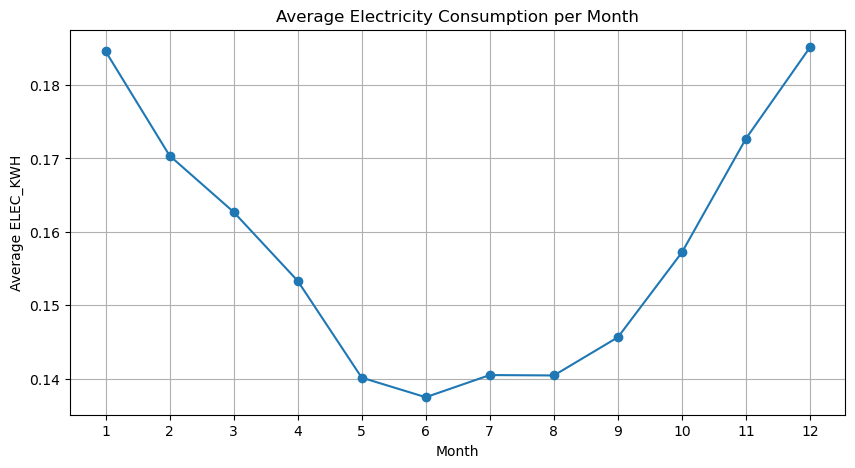

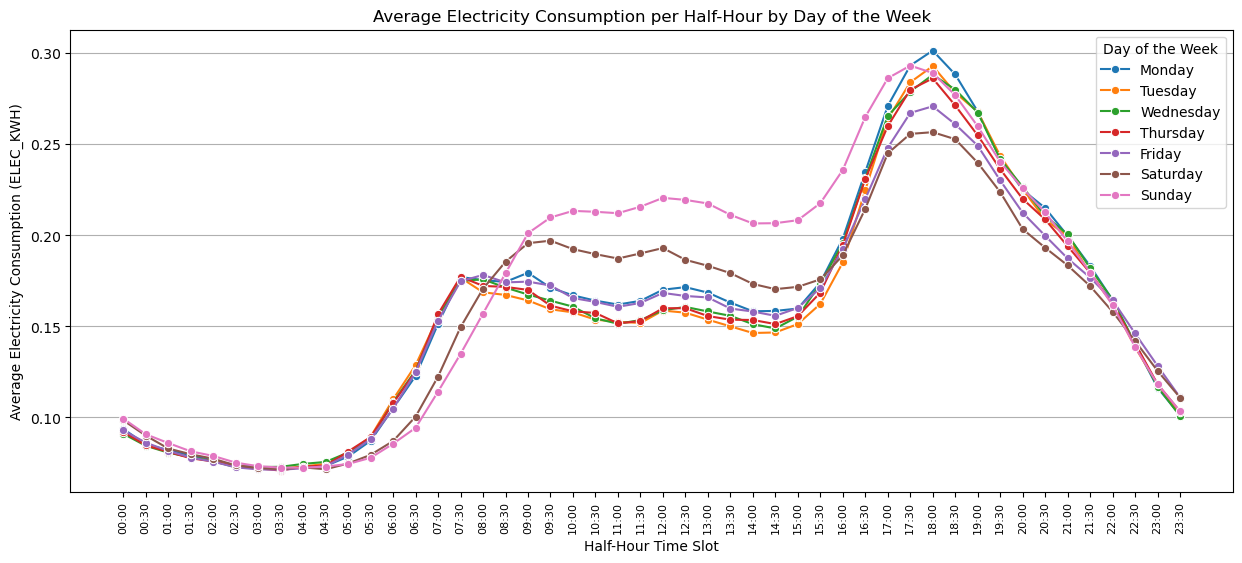

<Figure size 1500x600 with 0 Axes>

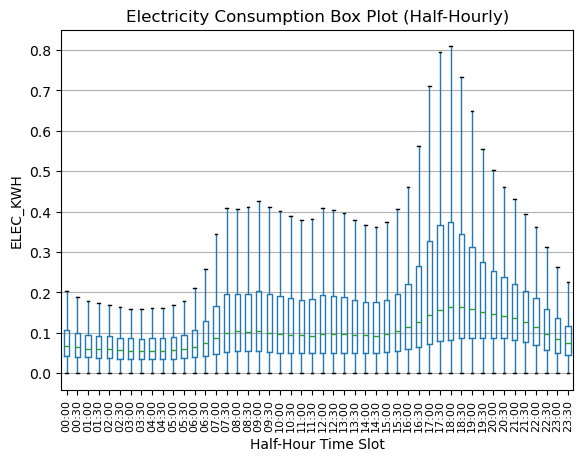

In [31]:
# Unpivot (melt) the dataset: Convert wide format to long format
df_control_long = df_control.melt(id_vars=['Time'], var_name='ID', value_name='ELEC_KWH')
df_control_long['Month'] = df_control_long['Time'].dt.month
df_control_long['DayOfWeek'] = df_control_long['Time'].dt.day_name()
df_control_long['HalfHour'] = df_control_long['Time'].dt.strftime('%H:%M')  # Captures half-hourly reading format


## 1. Plot: Average Consumption Across Months
monthly_avg = df_control_long.groupby('Month')['ELEC_KWH'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average ELEC_KWH')
plt.title('Average Electricity Consumption per Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


# Compute the average ELEC_KWH for each HalfHour and DayOfWeek across all IDs
df_avg_halfhour = df_control_long.groupby(['HalfHour', 'DayOfWeek'])['ELEC_KWH'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg_halfhour['DayOfWeek'] = pd.Categorical(df_avg_halfhour['DayOfWeek'], categories=day_order, ordered=True)

# Plot: Line chart for average electricity consumption per half-hour slot, with each line representing a day of the week
plt.figure(figsize=(15,6))
sns.lineplot(data=df_avg_halfhour, x="HalfHour", y="ELEC_KWH", hue="DayOfWeek", marker="o")
plt.xlabel("Half-Hour Time Slot")
plt.ylabel("Average Electricity Consumption (ELEC_KWH)")
plt.title("Average Electricity Consumption per Half-Hour by Day of the Week")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Day of the Week", bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.show()

## 3 Boxplot: Consumption Across Half-Hour Intervals Over the Year
plt.figure(figsize=(15,6))
df_control_long.boxplot(column='ELEC_KWH', by='HalfHour', grid=False, showfliers=False)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Half-Hour Time Slot')
plt.ylabel('ELEC_KWH')
plt.title('Electricity Consumption Box Plot (Half-Hourly)')
plt.suptitle('')  # Remove default boxplot title
plt.grid(axis='y')
plt.show()


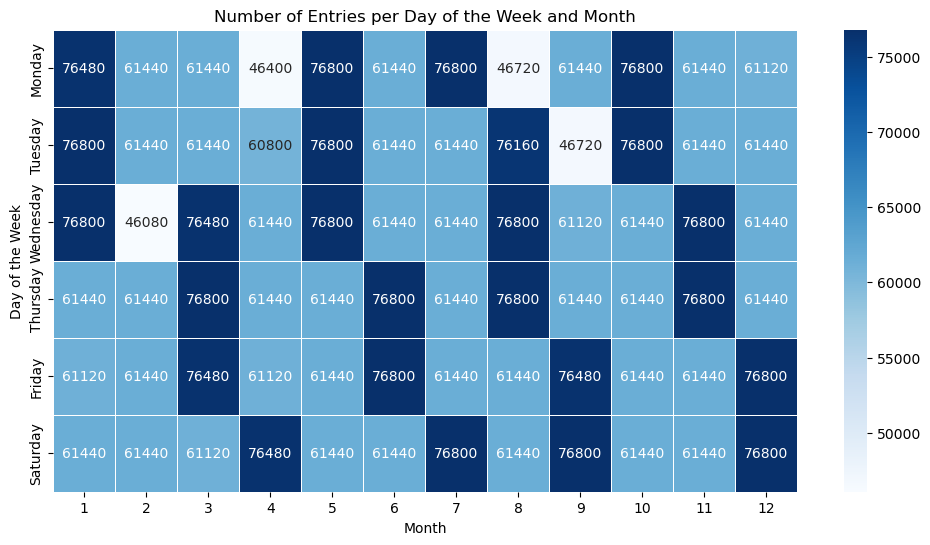

In [32]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Count occurrences per (Month, DayOfWeek)
entries_count = df_control_long.groupby(['DayOfWeek', 'Month']).size().unstack()
entries_count = entries_count.reindex(day_order)


plt.figure(figsize=(12,6))
sns.heatmap(entries_count, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.title("Number of Entries per Day of the Week and Month")
plt.show()



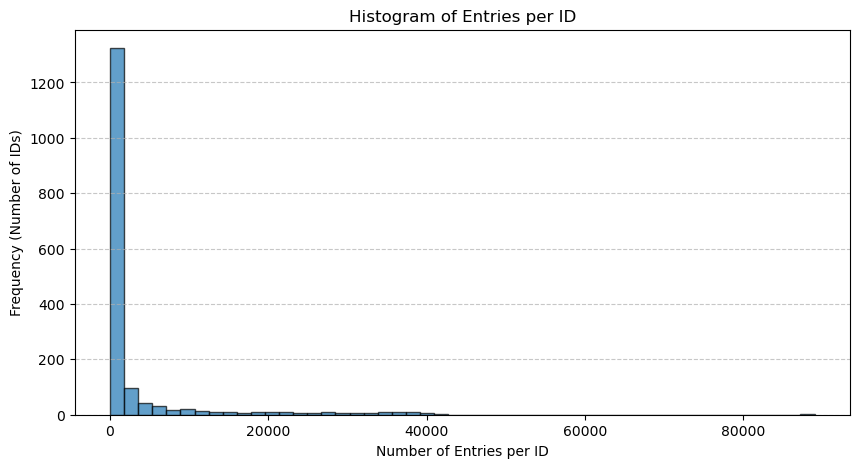

In [33]:
# Count the number of entries per ID
ID_entry_counts = df_control_long.groupby('ELEC_KWH').size()

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(ID_entry_counts, bins=50, edgecolor='black', alpha=0.7)

# Formatting the plot
plt.xlabel("Number of Entries per ID")
plt.ylabel("Frequency (Number of IDs)")
plt.title("Histogram of Entries per ID")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Preprocessing

Overview of Preprocessing: 

- Subset for just households that have socioeconomic data accompanying them (>95%)
- 

Making IDs for households and a dictionary matching IDs to hash keys to then drop the hash keys to improve readability

In [34]:
df_socio['ID'] = range(1,len(df_socio) + 1) # make IDs
id_dict = df_socio.set_index('HASH_KEY')['ID'].to_dict() # make dictionary with ID-hash key pairs 
df_socio = df_socio.drop(columns="HASH_KEY") # drop hash keys from table 

In [35]:

def data_with_socio(df, dict):
    columns_to_keep = [col for col in df.columns if col in dict]
    return df[columns_to_keep]


control_subset = data_with_socio(df_control, list(id_dict.keys()))
int_subset = data_with_socio(df_int, list(id_dict.keys()))

control_subset = control_subset.rename(columns=id_dict)
int_subset = int_subset.rename(columns=id_dict)

control_subset.insert(0, 'Time', df_control['Time'])
int_subset.insert(0, 'Time', df_int['Time'])

In [36]:
int_subset

,Time,456,46,151,454,1084,422,819,1069,315,...,212,654,966,1033,62,299,213,800,822,313
0,2023-02-02 00:00:00,0.071,0.105,0.082,0.052,0.058,0.052,0.045,0.025,0.024,...,0.099,0.030,0.106,0.029,0.056,0.050,0.014,0.038,0.048,0.026
1,2023-02-02 00:30:00,0.107,0.072,0.093,0.038,0.078,0.057,0.022,0.058,0.025,...,0.060,0.049,0.086,0.027,0.062,0.049,0.018,0.035,0.063,0.041
2,2023-02-02 01:00:00,0.115,0.089,0.083,0.046,0.074,0.061,0.057,0.070,0.025,...,0.033,0.049,0.088,0.028,0.049,0.050,0.030,0.041,0.086,0.027
3,2023-02-02 01:30:00,0.135,0.043,0.085,0.031,0.067,0.050,0.056,0.019,0.025,...,0.052,0.046,0.105,0.031,0.046,0.049,0.013,0.072,0.081,0.024
4,2023-02-02 02:00:00,0.093,0.057,0.062,0.057,0.059,0.048,0.059,0.018,0.025,...,0.049,0.047,0.084,0.060,0.063,0.048,0.022,0.036,0.048,0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17366,2024-01-31 21:30:00,0.229,0.120,0.139,0.024,0.095,0.072,0.066,0.075,0.076,...,0.064,0.269,0.264,0.096,0.262,0.527,0.015,0.241,0.072,0.182
17367,2024-01-31 22:00:00,0.181,0.099,0.036,0.024,0.061,0.068,0.038,0.078,0.086,...,0.132,0.237,0.272,0.084,0.055,0.163,0.031,0.155,0.080,0.113
17368,2024-01-31 22:30:00,0.107,0.115,0.068,0.023,0.079,0.060,0.106,0.051,0.090,...,0.105,0.186,0.276,0.076,0.048,0.078,0.014,0.064,0.049,0.084
17369,2024-01-31 23:00:00,0.047,0.120,0.038,0.043,0.056,0.049,0.034,0.030,0.073,...,0.131,0.067,0.215,0.058,0.049,0.115,0.026,0.083,0.058,0.027


In [37]:
# functions from first_checkpoint.ipynb script
# can be edited; less data -> less classes all around 
# from last meeting: different day classes beyond maybe just weekend vs weekday is not feasible 
# further: paper with day and month class breakdowns used all typed of consumers, not just households 
def get_day_class(day):
    if day == 0:  # Monday
        return 1
    elif day in [1, 2, 3]:  # Tuesday, Wednesday, Thursday
        return 2
    elif day == 4:  # Friday
        return 3
    elif day == 5:  # Saturday
        return 4
    elif day == 6:  # Sunday
        return 5

def get_month_class(month):
    if month in [12, 1, 2]:  # Dec, Jan, Feb
        return 1
    elif month == 3:  # March
        return 2
    elif month in [4, 5]:  # April, May
        return 3
    elif month in [6, 7, 9]:  # June, July, September
        return 4
    elif month == 8:  # August
        return 5
    elif month == 10:  # October
        return 6
    elif month == 11:  # November
        return 7


In [38]:
"""
for i in flash.columns:
    if type(i) == 'str' and len(i) > 10:
        flash.drop(columns=i)
    if np.isnan(flash[i]).sum() > 0:
        flash.drop(columns=i)
# cleaned = cleaned.drop(columns='Time')
"""


"\nfor i in flash.columns:\n    if type(i) == 'str' and len(i) > 10:\n        flash.drop(columns=i)\n    if np.isnan(flash[i]).sum() > 0:\n        flash.drop(columns=i)\n# cleaned = cleaned.drop(columns='Time')\n"

In [39]:
control_long = pd.melt(control_subset, id_vars='Time', var_name='ID', value_name='kWh')
int_long = pd.melt(int_subset, id_vars='Time', var_name='ID', value_name='kWh')


# adding HH interval
hh_c = (control_long['Time'].dt.hour * 2 + (control_long['Time'].dt.minute >= 30).astype(int))
control_long.insert(3,'HH',hh_c)

hh_i = (int_long['Time'].dt.hour * 2 + (int_long['Time'].dt.minute >= 30).astype(int))
int_long.insert(3,'HH',hh_i)



"""
Month, Day Class, and Month Class

# adding month
month = flash['Time'].dt.month
flash.insert(4,'Month',month)
# adding day class
day_class = flash['Time'].dt.weekday.apply(get_day_class)
flash.insert(5, 'Day Class', day_class)
# adding month class
month_class = flash['Time'].dt.month.apply(get_month_class)
flash.insert(6, 'Month Class', month_class)
"""


"\nMonth, Day Class, and Month Class\n\n# adding month\nmonth = flash['Time'].dt.month\nflash.insert(4,'Month',month)\n# adding day class\nday_class = flash['Time'].dt.weekday.apply(get_day_class)\nflash.insert(5, 'Day Class', day_class)\n# adding month class\nmonth_class = flash['Time'].dt.month.apply(get_month_class)\nflash.insert(6, 'Month Class', month_class)\n"

In [40]:
# flash.pivot(index='ID', columns='HH', values='kWh')
# df_pivot = df_filtered_dict[df_name].pivot(index='ID', columns='HH', values='kWh')

# control
flash_control = control_long.groupby(['ID', 'HH'])['kWh'].mean().reset_index()
flash_control = flash_control.pivot(index='ID', columns='HH', values='kWh')

flash_control.columns = [f'HH_{int(col):02d}' for col in flash_control.columns]
flash_control.reset_index(inplace=True)

# intervention
flash_int = int_long.groupby(['ID', 'HH'])['kWh'].mean().reset_index()
flash_int = flash_int.pivot(index='ID', columns='HH', values='kWh')

flash_int.columns = [f'HH_{int(col):02d}' for col in flash_int.columns]
flash_int.reset_index(inplace=True)


In [41]:
flash = pd.concat([flash_int, flash_control]).reset_index().drop(columns='index')


# Clustering Methods

## PCA + K-Means

Fitting and plotting PCs

Final Cluster Summary Table (PCA-space vs. Reconstructed Features):


,Cluster,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,0 PCA-space Avg,-7.075538,0.943877,0.392997,-0.175626,-0.162113,0.062946
1,1 PCA-space Avg,8.490538,0.094960,-0.622742,-0.040815,0.089557,0.192334
2,2 PCA-space Avg,-1.254611,-0.363742,-0.136214,0.014824,0.122140,-0.002863
3,3 PCA-space Avg,18.369472,0.206376,0.723559,-0.474043,-0.176132,-0.051213
4,4 PCA-space Avg,3.288835,-2.069278,0.286060,0.454458,-0.289091,-0.128372
5,5 PCA-space Avg,47.017547,9.819867,2.766986,-2.508727,-0.580825,0.466851
6,6 PCA-space Avg,-4.330308,0.349982,0.125608,-0.205106,-0.125904,0.030932
7,7 PCA-space Avg,2.343934,1.110925,-0.209917,0.275830,0.297518,-0.130126
8,0 Reconstructed Avg,-7.075538,0.943877,0.392997,-0.175626,-0.162113,0.062946
9,1 Reconstructed Avg,8.490538,0.094960,-0.622742,-0.040815,0.089557,0.192334


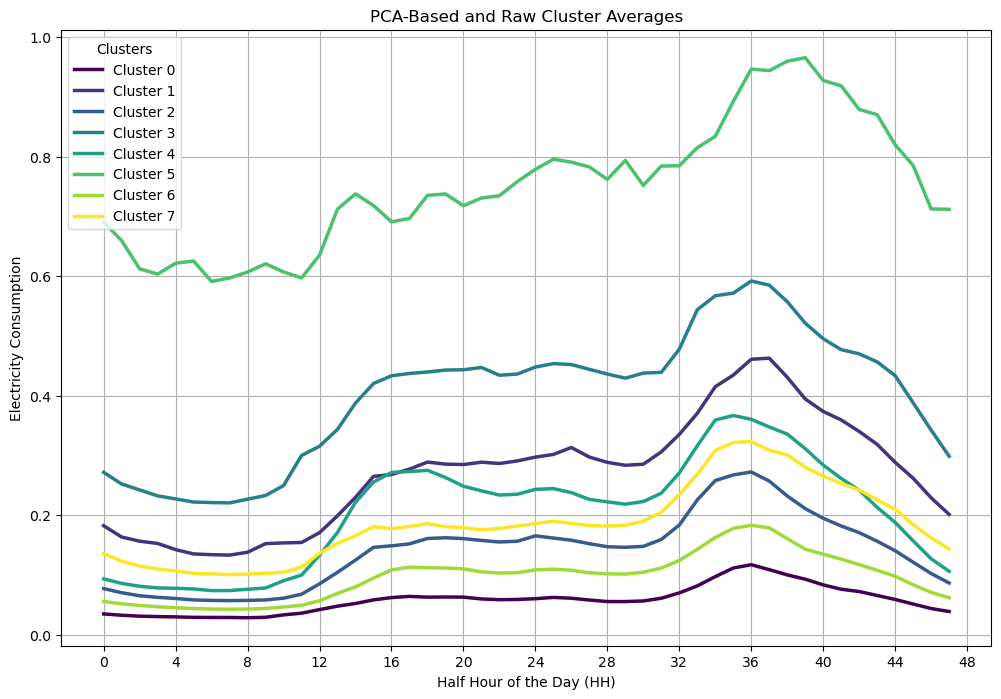

In [43]:
# 1) Define parameters
# ------------------------------------------------------------------------------
pca_components = 6                  
optimal_clusters = 8

# 2) Compute daily stats 
# ------------------------------------------------------------------------------
flash_pca = flash.drop(columns=["ID"])  
daily_avg = flash_pca.mean(axis=1).values  # shape (n_samples,)
daily_std = flash_pca.std(axis=1).values   # shape (n_samples,)
IDs = flash["ID"].values
flash_pca_values = flash_pca.values.astype(np.float64)  # shape (n_samples, 48)
# Turn daily_avg and daily_std into columns so we can horizontally stack them
daily_avg_col = daily_avg.reshape(-1, 1)  # shape (n_samples, 1)
daily_std_col = daily_std.reshape(-1, 1)  # shape (n_samples, 1)

# 3) Scale the raw half-hour data, then apply PCA
# ------------------------------------------------------------------------------
scaler_raw = StandardScaler()
flash_pca_scaled = scaler_raw.fit_transform(flash_pca_values)  # shape -> (n_samples, 48)
pca = PCA(n_components=pca_components, random_state=1)
pca_scores = pca.fit_transform(flash_pca_scaled)     # shape -> (n_samples, # of pca_components)

# 3) K-Means Clustering on the PCs
# ------------------------------------------------------------------------------
kmeans = KMeans(n_clusters=optimal_clusters, random_state=1)
clusters = kmeans.fit_predict(pca_scores)


# 6) Build a DataFrame of results and compute cluster means (raw PCA-scores)
# ------------------------------------------------------------------------------
pca_columns = [f'PCA_{i}' for i in range(pca_components)]

pca_df = pd.DataFrame(
    np.column_stack([pca_scores]),
    columns=pca_columns
)
pca_df["ID"] = IDs
pca_df["Cluster"] = clusters

# Compute cluster-level means in PCA-space + daily stats
cluster_feature_means = (
    pca_df.groupby("Cluster")[pca_columns].mean().reset_index()
)
cluster_feature_means["Cluster"] = cluster_feature_means["Cluster"].astype(str) + " PCA-space Avg"

# 7) Inverse PCA to approximate the original load curves
# ------------------------------------------------------------------------------
reconstructed_scaled = pca.inverse_transform(pca_scores)   # shape (n_samples, 48)
reconstructed_data = scaler_raw.inverse_transform(reconstructed_scaled)  
reconstructed_data = np.clip(reconstructed_data, a_min=0, a_max=None)  # ensure non-negative !!!

# Put reconstruction into a DataFrame
reconstructed_df = pd.DataFrame(
    reconstructed_data, 
    columns=[f'HH_{i:02d}' for i in range(flash_pca.shape[1])]
)
reconstructed_df["ID"] = IDs
reconstructed_df["Cluster"] = clusters


# 8) Merge for analyzing reconstructed vs. raw in the same pipeline
# ------------------------------------------------------------------------------
pca_df_no_cluster = pca_df.drop(columns="Cluster")
reconstructed_merged = reconstructed_df.merge(
    pca_df_no_cluster, 
    on="ID", 
    how="left"
)

# 9) Compute cluster-level means (reconstructed)
existing_cols = [c for c in pca_columns if c in reconstructed_merged.columns]
cluster_recon_means = (
    reconstructed_merged
    .groupby("Cluster")[existing_cols]
    .mean()
    .reset_index()
)
cluster_recon_means["Cluster"] = cluster_recon_means["Cluster"].astype(str) + " Reconstructed Avg"

# Create final summary table
cluster_summary_table = pd.concat([cluster_feature_means, cluster_recon_means], axis=0).reset_index(drop=True)
styled_table = cluster_summary_table.style.background_gradient(cmap="Blues")

print("Final Cluster Summary Table (PCA-space vs. Reconstructed Features):")
display(styled_table)

# 10) Plot Reconstructed vs. Raw cluster averages 
# ------------------------------------------------------------------------------
# A) Reconstructed-based average
df_long_recon = reconstructed_df.melt(
    id_vars=["ID", "Cluster"], 
    var_name="HH", 
    value_name="kWh"
)
# only keep numeric part from HH_XX
df_long_recon["HH"] = df_long_recon["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_recon = (
    df_long_recon.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Reconstructed_Avg_kWh"})
)

# B) Raw average
df_merged_raw = flash.merge(pca_df[["ID", "Cluster"]], on="ID", how="left")
df_long_raw = df_merged_raw.melt(id_vars=["ID", "Cluster"], var_name="HH", value_name="kWh")
df_long_raw["HH"] = df_long_raw["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_raw = (
    df_long_raw.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Raw_Avg_kWh"})
)

# C) Plot
plt.figure(figsize=(12, 8))
cluster_ids = sorted(cluster_avg_recon["Cluster"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_ids)))

for i, cid in enumerate(cluster_ids):
    # Raw-based
    raw_data = cluster_avg_raw[cluster_avg_raw["Cluster"] == cid]
    
    plt.plot(
        raw_data["HH"], raw_data["Raw_Avg_kWh"],
        color=colors[i], linewidth=2.5, label=f'Cluster {cid}'
    )

plt.title("PCA-Based and Raw Cluster Averages")
plt.xlabel("Half Hour of the Day (HH)")
plt.ylabel("Electricity Consumption")
plt.xticks(range(0, flash_pca.shape[1]+1, 4))
plt.legend(title="Clusters", loc="best")
plt.grid(True)
plt.show()


Cluster headcounts for PCA + KMeans

In [44]:
cluster_labels = pd.DataFrame({'Cluster' : clusters})
flash_clusters = flash['ID'].to_frame()
flash_clusters['Cluster'] = cluster_labels
flash_clusters['Cluster'].value_counts()

Cluster
2    220
6    158
7     82
4     76
0     65
1     63
3     19
5      2
Name: count, dtype: int64

Trimming Outliers

In [45]:
flash_clusters[flash_clusters['Cluster'] == 6]


,ID,Cluster
0,7,6
2,16,6
4,22,6
10,43,6
12,46,6
...,...,...
666,1074,6
668,1079,6
670,1089,6
672,1097,6


In [46]:
flash_trimmed = flash.drop(flash[flash['ID'] == 461].index)
flash_trimmed = flash_trimmed.drop(flash[flash['ID'] == 314].index)

PCA without 'Outliers'

Final Cluster Summary Table (PCA-space vs. Reconstructed Features):


,Cluster,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,0 PCA-space Avg,8.203352,-0.793861,-1.159813,-0.148751,-0.016716,0.264626
1,1 PCA-space Avg,-1.198254,-0.294960,-0.166616,0.014173,0.108597,-0.029369
2,2 PCA-space Avg,-7.475516,0.724604,0.347662,-0.143556,-0.167769,0.049330
3,3 PCA-space Avg,24.360383,0.623366,0.807730,-1.223328,-1.310895,-0.190241
4,4 PCA-space Avg,2.973191,-2.106656,0.641494,0.600906,-0.165485,-0.186166
5,5 PCA-space Avg,13.160832,2.199878,1.129942,-0.201508,0.222030,0.141895
6,6 PCA-space Avg,3.048074,1.413793,-0.219931,0.219152,0.285259,-0.105034
7,7 PCA-space Avg,-4.528952,0.129579,0.046016,-0.187252,-0.115899,0.057789
8,0 Reconstructed Avg,8.203352,-0.793861,-1.159813,-0.148751,-0.016716,0.264626
9,1 Reconstructed Avg,-1.198254,-0.294960,-0.166616,0.014173,0.108597,-0.029369


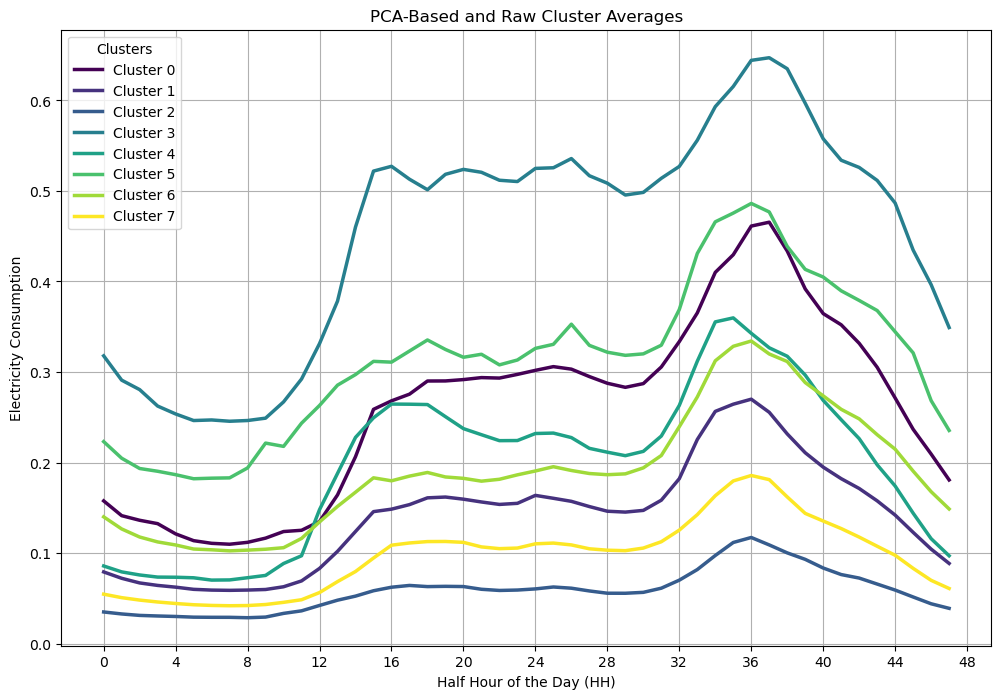

In [47]:
# 1) Define parameters
# ------------------------------------------------------------------------------
pca_components = 6                  
optimal_clusters = 8

# 2) Compute daily stats 
# ------------------------------------------------------------------------------
flash_pca = flash_trimmed.drop(columns=["ID"])  
daily_avg = flash_pca.mean(axis=1).values  # shape (n_samples,)
daily_std = flash_pca.std(axis=1).values   # shape (n_samples,)
IDs = flash_trimmed["ID"].values
flash_pca_values = flash_pca.values.astype(np.float64)  # shape (n_samples, 48)
# Turn daily_avg and daily_std into columns so we can horizontally stack them
daily_avg_col = daily_avg.reshape(-1, 1)  # shape (n_samples, 1)
daily_std_col = daily_std.reshape(-1, 1)  # shape (n_samples, 1)

# 3) Scale the raw half-hour data, then apply PCA
# ------------------------------------------------------------------------------
scaler_raw = StandardScaler()
flash_pca_scaled = scaler_raw.fit_transform(flash_pca_values)  # shape -> (n_samples, 48)
pca = PCA(n_components=pca_components, random_state=1)
pca_scores = pca.fit_transform(flash_pca_scaled)     # shape -> (n_samples, # of pca_components)

# 3) K-Means Clustering on the PCs
# ------------------------------------------------------------------------------
kmeans = KMeans(n_clusters=optimal_clusters, random_state=1)
clusters = kmeans.fit_predict(pca_scores)


# 6) Build a DataFrame of results and compute cluster means (raw PCA-scores)
# ------------------------------------------------------------------------------
pca_columns = [f'PCA_{i}' for i in range(pca_components)]

pca_df = pd.DataFrame(
    np.column_stack([pca_scores]),
    columns=pca_columns
)
pca_df["ID"] = IDs
pca_df["Cluster"] = clusters

# Compute cluster-level means in PCA-space + daily stats
cluster_feature_means = (
    pca_df.groupby("Cluster")[pca_columns].mean().reset_index()
)
cluster_feature_means["Cluster"] = cluster_feature_means["Cluster"].astype(str) + " PCA-space Avg"

# 7) Inverse PCA to approximate the original load curves
# ------------------------------------------------------------------------------
reconstructed_scaled = pca.inverse_transform(pca_scores)   # shape (n_samples, 48)
reconstructed_data = scaler_raw.inverse_transform(reconstructed_scaled)  
reconstructed_data = np.clip(reconstructed_data, a_min=0, a_max=None)  # ensure non-negative !!!

# Put reconstruction into a DataFrame
reconstructed_df = pd.DataFrame(
    reconstructed_data, 
    columns=[f'HH_{i:02d}' for i in range(flash_pca.shape[1])]
)
reconstructed_df["ID"] = IDs
reconstructed_df["Cluster"] = clusters


# 8) Merge for analyzing reconstructed vs. raw in the same pipeline
# ------------------------------------------------------------------------------
pca_df_no_cluster = pca_df.drop(columns="Cluster")
reconstructed_merged = reconstructed_df.merge(
    pca_df_no_cluster, 
    on="ID", 
    how="left"
)

# 9) Compute cluster-level means (reconstructed)
existing_cols = [c for c in pca_columns if c in reconstructed_merged.columns]
cluster_recon_means = (
    reconstructed_merged
    .groupby("Cluster")[existing_cols]
    .mean()
    .reset_index()
)
cluster_recon_means["Cluster"] = cluster_recon_means["Cluster"].astype(str) + " Reconstructed Avg"

# Create final summary table
cluster_summary_table = pd.concat([cluster_feature_means, cluster_recon_means], axis=0).reset_index(drop=True)
styled_table = cluster_summary_table.style.background_gradient(cmap="Blues")

print("Final Cluster Summary Table (PCA-space vs. Reconstructed Features):")
display(styled_table)

# 10) Plot Reconstructed vs. Raw cluster averages 
# ------------------------------------------------------------------------------
# A) Reconstructed-based average
df_long_recon = reconstructed_df.melt(
    id_vars=["ID", "Cluster"], 
    var_name="HH", 
    value_name="kWh"
)
# only keep numeric part from HH_XX
df_long_recon["HH"] = df_long_recon["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_recon = (
    df_long_recon.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Reconstructed_Avg_kWh"})
)

# B) Raw average
df_merged_raw = flash.merge(pca_df[["ID", "Cluster"]], on="ID", how="left")
df_long_raw = df_merged_raw.melt(id_vars=["ID", "Cluster"], var_name="HH", value_name="kWh")
df_long_raw["HH"] = df_long_raw["HH"].str.extract(r'(\d+)').astype(int)
cluster_avg_raw = (
    df_long_raw.groupby(["Cluster", "HH"])["kWh"]
    .mean()
    .reset_index()
    .rename(columns={"kWh": "Raw_Avg_kWh"})
)

# C) Plot
plt.figure(figsize=(12, 8))
cluster_ids = sorted(cluster_avg_recon["Cluster"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_ids)))

for i, cid in enumerate(cluster_ids):
    # Raw-based
    raw_data = cluster_avg_raw[cluster_avg_raw["Cluster"] == cid]
    
    plt.plot(
        raw_data["HH"], raw_data["Raw_Avg_kWh"],
        color=colors[i], linewidth=2.5, label=f'Cluster {cid}'
    )

plt.title("PCA-Based and Raw Cluster Averages")
plt.xlabel("Half Hour of the Day (HH)")
plt.ylabel("Electricity Consumption")
plt.xticks(range(0, flash_pca.shape[1]+1, 4))
plt.legend(title="Clusters", loc="best")
plt.grid(True)
plt.show()


Silhouette Score for Number of Clusters 

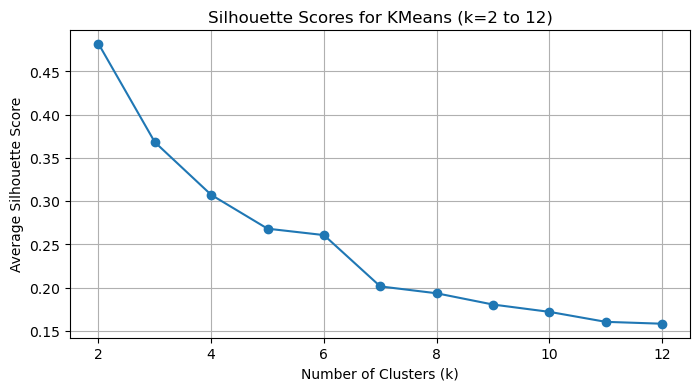

In [48]:

# Suppose X is your *scaled* feature matrix used for clustering,
# e.g. combined_features_scaled_24_comp_tuned from your PCA or FFT approach.

silhouette_scores = []
clusters_range = range(2, 13)  # 2 to 12

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=1)

    labels = kmeans.fit_predict(pca_scores)
    # Compute average silhouette score for this k
    sil_score = silhouette_score(pca_scores, labels)
    silhouette_scores.append(sil_score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(list(clusters_range), silhouette_scores, marker='o')
plt.title("Silhouette Scores for KMeans (k=2 to 12)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()


Most distant IDs in feature space for cluster 1: 1104.0, 217.0


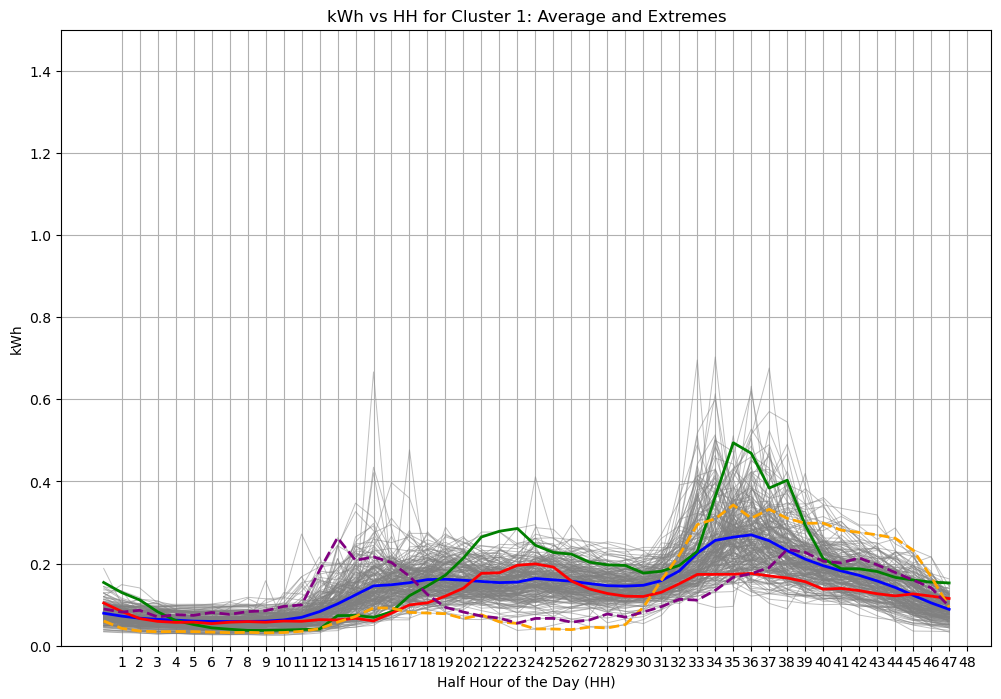

Feature Table for Cluster 1 and Extreme IDs:


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
ID,,,,,,
Cluster_Average,-1.198254,-0.294960,-0.166616,0.014173,0.108597,-0.029369
375,1.417321,-1.169187,-2.997251,-0.886393,1.033885,0.913318
639,-2.553502,0.524135,-0.518323,-1.662112,-0.128096,0.098817
1104.0,-2.957341,0.969648,-3.218773,3.485570,1.235381,-1.186400
217.0,-1.997050,2.738416,1.626876,2.605882,-1.132197,-0.769120


In [49]:
# ---------------------------------------------------------------------------
# Let's assume you have a final KMeans model trained on X (scaled features),
# and a DataFrame df_all with columns:
#   ID, HH, kWh, Cluster, and so on
# ---------------------------------------------------------------------------
feature_cols = pca_columns
df_features = pca_df
df_long_raw = df_merged_raw.melt(id_vars=["ID", "Cluster"], var_name="HH", value_name="kWh")
df_long_raw["HH"] = df_long_raw["HH"].str.extract(r'(\d+)').astype(int)
df_all = df_long_raw

target_cluster = 1  # the cluster you want to inspect

# ---------------------------
# A) Filter data for the target cluster
# ---------------------------
cluster_data = df_all[df_all['Cluster'] == target_cluster].copy()

# Group by ID and HH to get average consumption per half-hour per ID.
cluster_avg_by_anon = (
    cluster_data.groupby(['ID', 'HH'])['kWh']
    .mean()
    .reset_index()
)

# ---------------------------
# B) Compute the cluster's average load curve
# ---------------------------
cluster_avg = (
    cluster_avg_by_anon
    .groupby('HH')['kWh']
    .mean()
    .reset_index()
    .rename(columns={'kWh': 'Cluster_Avg_kWh'})
)

# Merge the cluster average back with the individual ID data
cluster_data_merged = cluster_data.merge(cluster_avg, on='HH', how='left')

# ---------------------------
# C) Identify extremes based on difference from cluster average
# ---------------------------
# "Difference" = kWh - Cluster_Avg_kWh for each half hour
cluster_data_merged['Difference'] = cluster_data_merged['kWh'] - cluster_data_merged['Cluster_Avg_kWh']

# Calculate the mean difference PER ID
anon_diff = (
    cluster_data_merged.groupby('ID')['Difference']
    .mean()
    .reset_index()
    .rename(columns={'Difference': 'Mean_Difference'})
)

most_positive_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmax(), 'ID']
most_negative_anon = anon_diff.loc[anon_diff['Mean_Difference'].idxmin(), 'ID']

# ---------------------------
# D) Identify extremes based on distance to cluster centroid in feature space
# ---------------------------
# 1) We need the cluster centroid in scaled space.
#    We'll retrieve the scaled centroid from the trained KMeans model:
centroids_scaled = kmeans.cluster_centers_  # shape (n_clusters, n_features)
target_centroid_scaled = centroids_scaled[target_cluster]  # shape (n_features,)

# 2) For each ID in this cluster, compute the distance from that centroid in scaled space.
#    That means we need the scaled features for each ID. 
#    Suppose you have a DataFrame "df_features" with columns: [ID] + feature columns + [Cluster]

#    and "X" is the scaled matrix. We'll do a merge or map.
df_cluster_features = df_features[df_features['Cluster'] == target_cluster].copy()

# Let's extract only the feature columns that match X's structure. 

# (Assume "feature_cols" is the list of columns used for KMeans.)
feature_array = df_cluster_features[feature_cols].values  # shape (samples_in_cluster, n_features)

# Distances in scaled space (Euclidean)
distances = np.linalg.norm(feature_array - target_centroid_scaled, axis=1)

df_cluster_features['Dist_Centroid'] = distances

# Let's pick the two IDs with largest distances:
idx_sort = df_cluster_features['Dist_Centroid'].argsort()[::-1]  # sort descending
furthest_1 = df_cluster_features.iloc[idx_sort.iloc[0]]['ID']
furthest_2 = df_cluster_features.iloc[idx_sort.iloc[1]]['ID']

print(f"Most distant IDs in feature space for cluster {target_cluster}: {furthest_1}, {furthest_2}")

# ---------------------------
# E) Plot all time-series + extremes
# ---------------------------
plt.figure(figsize=(12, 8))

# Plot all time-series in grey
for ID in cluster_avg_by_anon['ID'].unique():
    anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == ID]
    plt.plot(anon_data['HH'], anon_data['kWh'], color='grey', alpha=0.5, linewidth=0.7)

# Plot the cluster average in blue
plt.plot(
    cluster_avg['HH'], cluster_avg['Cluster_Avg_kWh'],
    color='blue', linewidth=2, label=f'Cluster {target_cluster} Average'
)

# Plot extremes based on difference from cluster average
positive_anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == most_positive_anon]
negative_anon_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == most_negative_anon]

plt.plot(
    positive_anon_data['HH'], positive_anon_data['kWh'],
    color='green', linewidth=2, label=f'Most Positive vs Avg: {most_positive_anon}'
)
plt.plot(
    negative_anon_data['HH'], negative_anon_data['kWh'],
    color='red', linewidth=2, label=f'Most Negative vs Avg: {most_negative_anon}'
)

# Plot extremes based on centroid distance
# (just to visually see them - choose another color scheme)
furthest_anon_1_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == furthest_1]
furthest_anon_2_data = cluster_avg_by_anon[cluster_avg_by_anon['ID'] == furthest_2]

plt.plot(
    furthest_anon_1_data['HH'], furthest_anon_1_data['kWh'],
    color='orange', linestyle='--', linewidth=2, 
    label=f'Furthest in Feature Space: {furthest_1}'
)
plt.plot(
    furthest_anon_2_data['HH'], furthest_anon_2_data['kWh'],
    color='purple', linestyle='--', linewidth=2, 
    label=f'Furthest in Feature Space: {furthest_2}'
)

# Plot details
plt.title(f'kWh vs HH for Cluster {target_cluster}: Average and Extremes')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('kWh')
plt.ylim(0,1.5)
plt.xticks(range(1, 49))  # or range(0,48) depending on your HH labels
plt.legend
plt.grid(True)
plt.show()

# ---------------------------
# F) Create a small feature table
# ---------------------------
# We want to compare:
#   - the cluster average (in feature space),
#   - the "most positive" ID,
#   - the "most negative" ID,
#   - the "furthest_1" and "furthest_2" from centroid
#
# For the cluster average in feature space, we can take the mean of feature columns
# specifically for target_cluster. For the 4 unique IDs, we do the same.

unique_ids = [most_positive_anon, most_negative_anon, furthest_1, furthest_2]
# some might coincide if the same ID is "most positive" and also "furthest from centroid"
# A small helper function that returns the row of mean features for the entire cluster
def get_cluster_mean_features(cluster_id):
    subset = df_features[df_features['Cluster'] == cluster_id]
    return subset[feature_cols].mean()

cluster_avg_features = get_cluster_mean_features(target_cluster)

# For each of the extreme IDs, compute mean of the features (or you might do just the single row if they have 1 row)
extreme_features = {}
for a_id in unique_ids:
    subset_id = df_features[df_features['ID'] == a_id]
    if len(subset_id) == 0:
        continue
    ext_mean = subset_id[feature_cols].mean()
    extreme_features[a_id] = ext_mean

# Build a combined DataFrame
table_data = {}
table_data['Cluster_Average'] = cluster_avg_features.to_dict()

for a_id, vals in extreme_features.items():
    table_data[a_id] = vals.to_dict()

table_df = pd.DataFrame(table_data).T
table_df.index.name = 'ID'
print(f"Feature Table for Cluster {target_cluster} and Extreme IDs:")
display(table_df)



## PCA with GMM

In [50]:
def clustermeasure(vec1, vec2, alpha):
    """
    Compute similarity measure between two 48-dimensional vectors (half-hour readings).
    
    The measure is:
        0.8 * sum(|(v1[h] / mean(v1)) - (v2[h] / mean(v2))|) + 
        0.2 * |mean(v1) - mean(v2)|
    """
    mean1 = vec1.mean()
    mean2 = vec2.mean()
    # Differences from each vector's mean
    centered_diff = np.abs((vec1 / mean1) - (vec2 / mean2))
    measure_centered = np.sum(centered_diff)
    measure_mean = np.abs(mean1 - mean2)
    
    return (alpha) * measure_centered + (1-alpha) * measure_mean

def average_clustermeasure_to_centroid(data_original, labels, n_clusters, cluster_centroids, alpha):
    
    n_samples = data_original.shape[0]
    sum_measure = 0.0
    for i in range(n_samples):
        c = labels[i]
        sum_measure += clustermeasure(data_original[i], cluster_centroids[c], alpha)
    return sum_measure / n_samples 

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

manycluster = 25  # Reduce from 100 for computational efficiency

# ------------------------------------------------------------------------------
# 1) Prepare Data
# ------------------------------------------------------------------------------
flash_gmm = flash.drop(columns=["ID"])  
IDs = flash["ID"].values  # Household IDs

# Convert to NumPy
flash_gmm_values = flash_gmm.values.astype(np.float64)

# Scale the raw half-hour data
scaler_raw = StandardScaler()
flash_gmm_scaled = scaler_raw.fit_transform(flash_gmm_values)

# ------------------------------------------------------------------------------
# 2) Define Ranges for PCA and GMM
# ------------------------------------------------------------------------------
n_components_list = [4, 5, 6, 7, 8, 9, 10, 11, 12]  # Number of PCA components
clusters_range = range(2, manycluster)  # GMM clusters from 2 to manycluster

results = []

# ------------------------------------------------------------------------------
# 3) Loop over PCA components and GMM clusters
# ------------------------------------------------------------------------------
for n_comp in n_components_list:
    
    # Apply PCA
    pca = PCA(n_components=n_comp, random_state=1)
    pca_scores = pca.fit_transform(flash_gmm_scaled)

    # Standardize PCA scores
    scaler_pca = StandardScaler()
    combined_features_scaled = scaler_pca.fit_transform(pca_scores)

    # Loop over different numbers of clusters
    for k in clusters_range:
        
        # Fit Gaussian Mixture Model (GMM)
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=1)
        labels = gmm.fit_predict(combined_features_scaled)

        # Compute silhouette score
        sil_score = silhouette_score(combined_features_scaled, labels)

        # Extract cluster centroids from GMM means (in PCA space)
        gmm_means_pca = gmm.means_  # GMM's "centroids" in PCA space
        
        # Ensure the number of centroids matches `k`
        if gmm_means_pca.shape[0] != k:
            print(f"Warning: Expected {k} centroids but found {gmm_means_pca.shape[0]}. Skipping this iteration.")
            continue  # Skip this iteration if centroids do not match the expected number

        # Inverse PCA transformation to reconstruct original 48-HH space
        gmm_centroids_scaled = pca.inverse_transform(gmm_means_pca)
        # Inverse scaling to get back to original consumption units
        cluster_centroids_original = scaler_raw.inverse_transform(gmm_centroids_scaled)

        # Compute the cluster measure
        avg_meas = average_clustermeasure_to_centroid(
            data_original=flash_gmm_values, 
            labels=labels,
            n_clusters=k,
            cluster_centroids=cluster_centroids_original,
            alpha=0.8
        )

        # Store results
        results.append({
            "n_components": n_comp,
            "n_clusters": k,
            "silhouette": sil_score,
            "avg_clustermeasure": avg_meas
        })

# Convert results to DataFrame
results_df_gmm = pd.DataFrame(results)




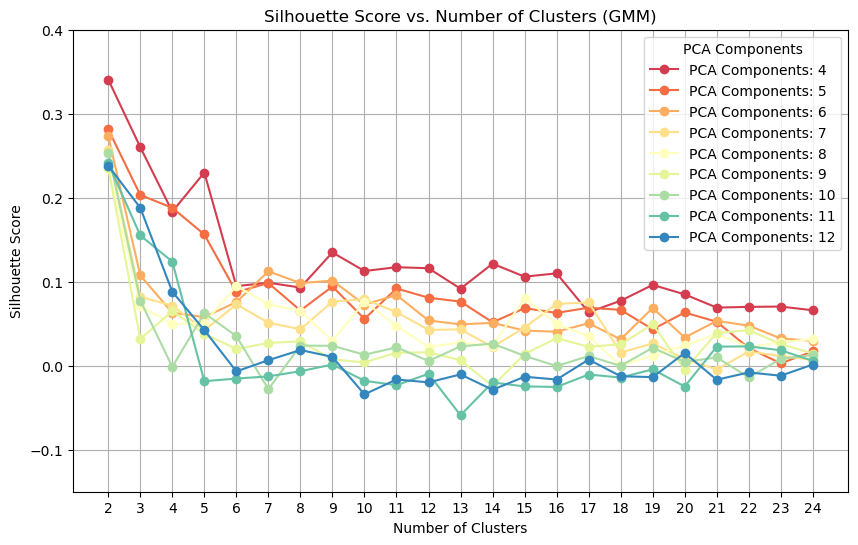

In [52]:
plt.figure(figsize=(10, 6))

# Define color palette
colors = sns.color_palette("Spectral", len(results_df_gmm["n_components"].unique()))

# Loop over different PCA components
for i, n_comp in enumerate(results_df_gmm["n_components"].unique()):
    subset = results_df_gmm[results_df_gmm["n_components"] == n_comp]
    
    # Plot Silhouette Score
    plt.plot(
        subset["n_clusters"], subset["silhouette"], marker='o', linestyle='-', 
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

# Formatting
plt.title("Silhouette Score vs. Number of Clusters (GMM)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, manycluster))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(-0.15,0.4)
plt.show()


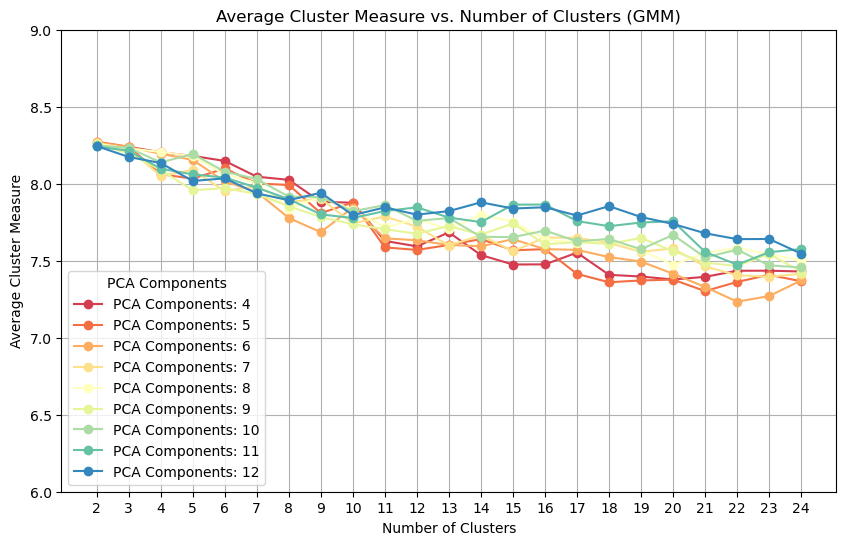

In [53]:
plt.figure(figsize=(10, 6))

# Define color palette
colors = sns.color_palette("Spectral", len(results_df_gmm["n_components"].unique()))

# Loop over different PCA components
for i, n_comp in enumerate(results_df_gmm["n_components"].unique()):
    subset = results_df_gmm[results_df_gmm["n_components"] == n_comp]
    
    # Plot Silhouette Score
    plt.plot(
        subset["n_clusters"], subset["avg_clustermeasure"], marker='o', linestyle='-', 
        label=f'PCA Components: {n_comp}', color=colors[i]
    )

# Formatting
plt.title("Average Cluster Measure vs. Number of Clusters (GMM)")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Cluster Measure")
plt.xticks(range(2, manycluster))
plt.legend(title="PCA Components")
plt.grid(True)
plt.ylim(6,9)
plt.show()



## Spectral Clustering for Outliers 

## "Old" Methods (Slovenian Paper)

In [54]:
# combining control and intervention dataframes (both pre-messaging) 
long = pd.concat([control_long, int_long])

In [55]:
# function to assign HH to time-of-day split above
def hh_group(hh):
    if 12 <= hh <= 20:
        return 'bre'  # 'breakfast'
    elif 21 <= hh <= 32:
        return 'day'  # 'daytime'
    elif 33 <= hh <= 44:
        return 'eve'  # 'evening'
    else:
        return 'nig'  # 'night'
    
long['HH_Group'] = long['HH'].map(hh_group)


Adding RME

In [56]:
mean_by_group = (
    long.groupby(['ID', 'HH_Group'])['kWh']
    .mean()
    .reset_index()
)
mean_overall = (
    long.groupby('ID')['kWh']
    .mean()
    .reset_index()
)
mean_overall = mean_overall.rename(columns={'kWh': 'Overall_Mean'})

# merging grouped mean with the overall mean
merged = mean_by_group.merge(mean_overall, on='ID')

# calculating RME
merged['RME'] = merged['kWh'] / merged['Overall_Mean']

# Pivot the table to have RME_bre, RME_day, RME_eve, RME_nig as columns
df_rme = merged.pivot(index='ID', columns='HH_Group', values='RME').reset_index()
df_rme = df_rme.rename(columns={ 'bre': 'RME_bre',
                                 'day': 'RME_day',
                                 'eve': 'RME_eve',
                                 'nig': 'RME_nig', 
                                 'am' : 'RME_am', 
                                 'aft' : 'RME_aft'})

# Reset index to remove hierarchical indexing (if present)
df_rme.columns.name = None

print(df_rme)

       ID   RME_bre   RME_day   RME_eve   RME_nig
0       1  0.714392  1.267127  1.479393  0.574893
1       3  1.186586  1.115209  1.378846  0.493339
2       5  0.996279  1.037804  1.651952  0.459724
3       6  1.240585  0.936618  1.447483  0.549836
4       7  0.706383  1.217858  1.773655  0.383329
..    ...       ...       ...       ...       ...
680  1131  0.791934  1.250551  1.609611  0.439850
681  1132  1.870670  0.918876  1.044383  0.508867
682  1133  0.763762  0.851730  1.727584  0.678731
683  1136  0.950579  1.091272  1.410389  0.628815
684  1137  1.137648  1.028464  1.623272  0.409421

[685 rows x 5 columns]


Adding RSD

In [57]:
long['Date'] = long['Time'].dt.date


# getting mean and standard deviation of consumption levels for each ID and HH_Group
rsd_df = (
    long.groupby(['ID'])['kWh']
    .agg(['mean', 'std'])
    .reset_index()
)

rsd_df['RSD'] = (rsd_df['std'] / rsd_df['mean'])
rsd_df = rsd_df.drop(columns=['mean', 'std'])

# merging RME & RSD features
long_features = df_rme.merge(rsd_df, on='ID', how='left')

# daily max-min difference
daily_stats = long.groupby(['ID', 'Date'])['kWh'].agg(['max', 'min']).reset_index()
daily_stats['ADR'] = daily_stats['max'] - daily_stats['min'] 

# average daily max-min difference for each ID
avg_daily_diff = daily_stats.groupby('ID')['ADR'].mean().reset_index()

# merging new feature in 
long_features = pd.merge(long_features, avg_daily_diff, on='ID', how='left')

'''
#Drop RSD_avg greater than 2
edrp_features = edrp_features[edrp_features['RSD_avg'] <= 2.2]
edrp_features = edrp_features.reset_index(drop=True)
'''

"\n#Drop RSD_avg greater than 2\nedrp_features = edrp_features[edrp_features['RSD_avg'] <= 2.2]\nedrp_features = edrp_features.reset_index(drop=True)\n"

In [58]:
features = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD', 'ADR']
X = long_features[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Gaussian Mixture Model with 6 clusters
gmm = GaussianMixture(n_components=6, random_state=1)  # INPUT THE OPTIMAL NUMBER OF CLUSTERS
long_features['Cluster'] = gmm.fit_predict(X_scaled)

# Count the number of consumers per cluster
cluster_counts = long_features['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Number_of_Consumers']

# Sort the clusters for better readability
cluster_counts = cluster_counts.sort_values(by='Cluster').reset_index(drop=True)

# Display the cluster counts
display(cluster_counts)

,Cluster,Number_of_Consumers
0,0,39
1,1,61
2,2,20
3,3,21
4,4,116
5,5,428


In [59]:
selected_attributes = ['RME_bre', 'RME_eve', 'RME_day', 'RME_nig', 'RSD', 'ADR']

# Group by Cluster and calculate the mean for each attribute
cluster_means = long_features.groupby('Cluster')[selected_attributes].mean().reset_index().round(2)
cluster_means['# of Consumers'] = cluster_counts['Number_of_Consumers']

# Apply color scale using Pandas Styler
def apply_color_scale(df):
    # Apply different color scales for features and the count column
    styled = df.style.background_gradient(cmap="coolwarm", subset=selected_attributes, axis=0)
    styled = styled.background_gradient(cmap="coolwarm", subset=['# of Consumers'], axis=0)
    return styled.format(precision=2)
# Apply the color scale to the DataFrame
styled_cluster_means = apply_color_scale(cluster_means)

# Display the styled DataFrame
styled_cluster_means

,Cluster,RME_bre,RME_eve,RME_day,RME_nig,RSD,ADR,# of Consumers
0,0,1.00,1.44,1.03,0.64,1.08,1.09,39
1,1,0.98,1.51,0.95,0.65,1.63,0.69,61
2,2,1.18,1.43,1.17,0.43,1.30,0.95,20
3,3,0.78,1.79,1.03,0.49,1.47,1.03,21
4,4,1.03,1.49,1.13,0.49,1.18,0.94,116
5,5,0.98,1.47,1.11,0.55,1.16,0.61,428


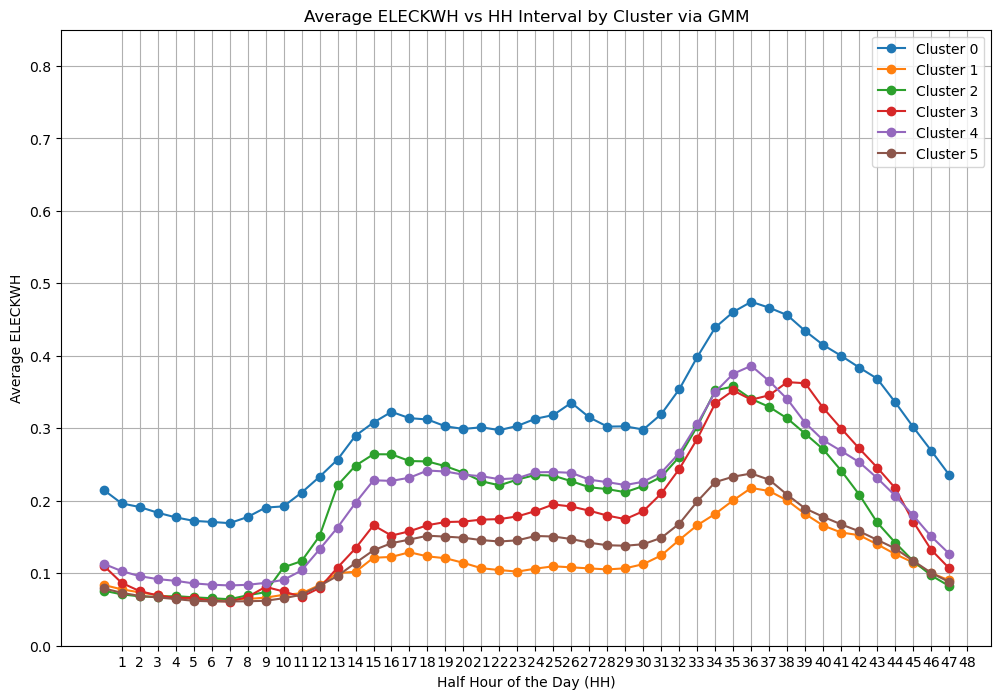

In [60]:
# Merge cluster information back into the original data (if not already included)
df_with_clusters = long.merge(
    long_features[['ID', 'Cluster']],
    on='ID',
    how='inner'
)
# Group by Cluster and HH, and calculate the mean ELECKWH
clustered_means = df_with_clusters.groupby(['Cluster', 'HH'])['kWh'].mean().reset_index()

# Plot each cluster
plt.figure(figsize=(12, 8))
for cluster in clustered_means['Cluster'].unique():
    cluster_data = clustered_means[clustered_means['Cluster'] == cluster]
    plt.plot(cluster_data['HH'], cluster_data['kWh'], label=f'Cluster {cluster}', marker='o')

# Plot details
plt.title('Average ELECKWH vs HH Interval by Cluster via GMM')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(1, 49))  # HH typically ranges from 1 to 48
plt.legend()
plt.ylim(0,.85)
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
GRF = pd.read_csv("/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/Notebooks/ANON_ID_w_socio_and_clusters.csv")


In [64]:
GRF['ANON_ID'] = GRF['ANON_ID'].map(id_dict)


In [66]:
flash_GRF = flash[flash['ID'].isin(GRF['ANON_ID'])]


In [67]:
flash_GRF

,ID,HH_00,HH_01,HH_02,HH_03,HH_04,HH_05,HH_06,HH_07,HH_08,...,HH_38,HH_39,HH_40,HH_41,HH_42,HH_43,HH_44,HH_45,HH_46,HH_47
0,7,0.034504,0.034418,0.034137,0.033416,0.032162,0.033526,0.032340,0.033295,0.033471,...,0.175596,0.131089,0.119791,0.103554,0.095950,0.092056,0.077136,0.053142,0.041437,0.038050
1,13,0.239454,0.237326,0.236856,0.224442,0.182535,0.164163,0.148122,0.137853,0.145518,...,0.325564,0.307947,0.312383,0.309481,0.308091,0.281593,0.290418,0.298247,0.267393,0.241086
2,16,0.102875,0.093848,0.084731,0.076364,0.069870,0.065191,0.062452,0.058742,0.057745,...,0.198461,0.205328,0.193762,0.177186,0.172587,0.178197,0.166964,0.149920,0.139028,0.120648
3,17,0.162493,0.163922,0.151620,0.151198,0.153799,0.141401,0.135861,0.128869,0.115813,...,0.188103,0.183240,0.174872,0.189986,0.178591,0.185432,0.191950,0.175694,0.185008,0.197894
4,22,0.029673,0.027464,0.027825,0.027331,0.028033,0.027870,0.027997,0.027712,0.026668,...,0.104886,0.092994,0.103050,0.106302,0.100501,0.097424,0.081235,0.055604,0.039263,0.033207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,1123,0.080861,0.063724,0.060423,0.054908,0.053283,0.053369,0.052344,0.053428,0.056367,...,0.214567,0.185997,0.166258,0.152028,0.162100,0.165372,0.158508,0.162300,0.131506,0.110867
681,1131,0.088578,0.072039,0.068100,0.068574,0.066933,0.064883,0.065347,0.065364,0.064442,...,0.358746,0.348656,0.238908,0.198839,0.171411,0.158561,0.185053,0.161217,0.146089,0.132428
682,1133,0.105531,0.097326,0.086916,0.081535,0.073517,0.065056,0.059589,0.057478,0.056958,...,0.220154,0.180363,0.169877,0.150453,0.141723,0.139715,0.133757,0.122872,0.123919,0.112382
683,1136,0.173727,0.154687,0.144059,0.138765,0.137017,0.131496,0.130270,0.132476,0.124568,...,0.366195,0.388267,0.377365,0.342111,0.304680,0.285699,0.257273,0.232911,0.224022,0.200808


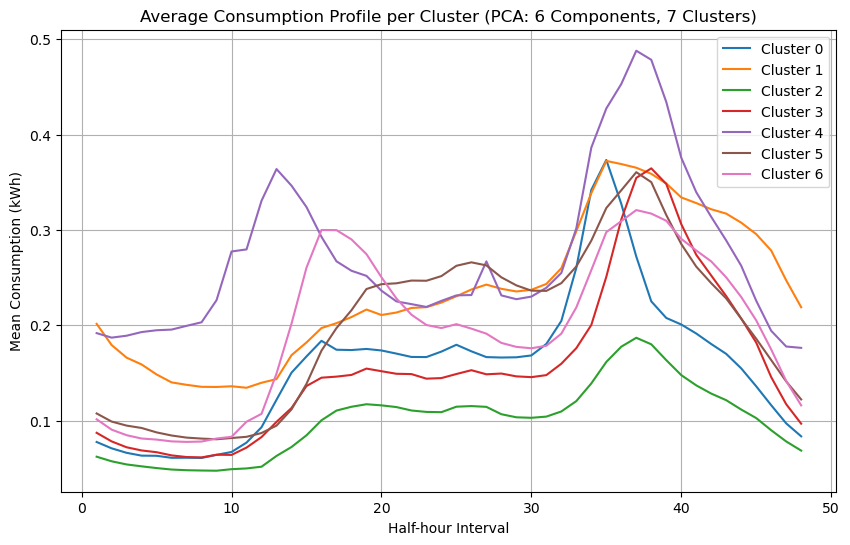

   Cluster  Household Count
0        0               84
1        1               43
2        2              237
3        3               78
4        4                9
5        5              107
6        6               56


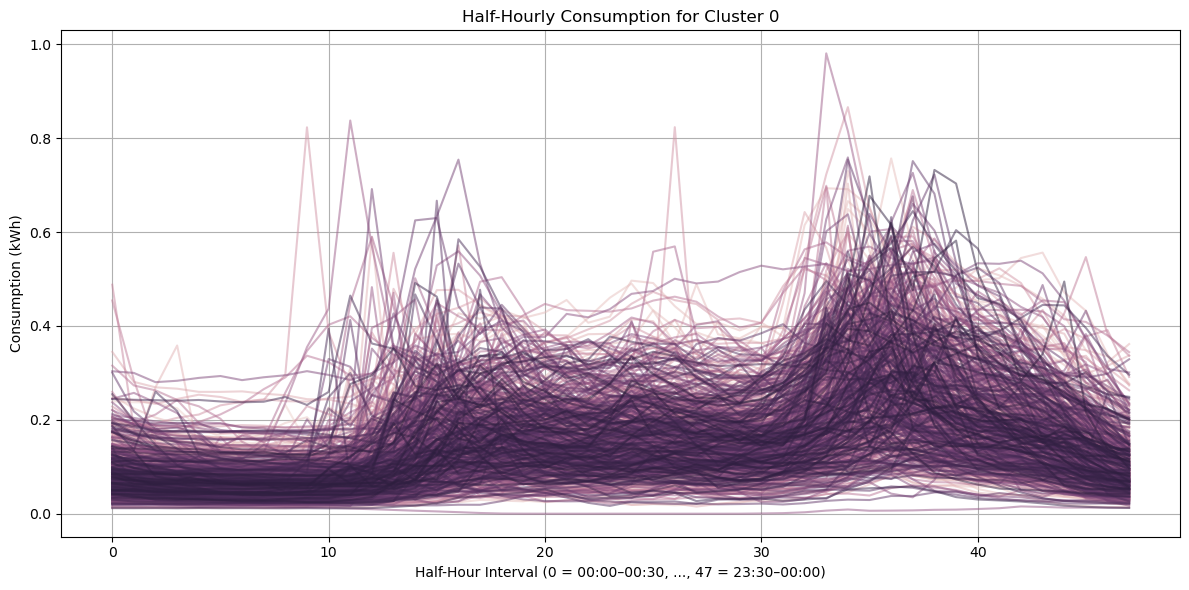

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Keep only rows in df24_clean where ANON_ID is in df_merged_with_clusters
df24_clean = flash_GRF


# Set max number of clusters to explore
max_clusters = 5
# Set the k++ hyperparameter
n_init = 20
# What specific cluster do you want to visualize
cluster_id = 0  # <-- Change this to any cluster you want to visualize
# ----------------------------------------------------------------------------
# Step 0: Prepare Data
# ----------------------------------------------------------------------------
df24_clean = df24_clean.copy()
anon_ids = df24_clean["ID"].values

data_24 = df24_clean.drop(columns=["ID"])
data_24_values = data_24.values.astype(np.float64)

# Standardize raw consumption data
scaler_raw = StandardScaler()
data_24_scaled = scaler_raw.fit_transform(data_24_values)

# ----------------------------------------------------------------------------
# Step 1: Grid Search over PCA components and K values with KMeans++
# ----------------------------------------------------------------------------
n_components_list = [5,6]
clusters_range = range(2, max_clusters)

results = []

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp, random_state=42)
    pca_scores = pca.fit_transform(data_24_scaled)

    scaler_pca = StandardScaler()
    pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

    for k in clusters_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, random_state=42)
        labels = kmeans.fit_predict(pca_scores_scaled)

        sil_score = silhouette_score(pca_scores_scaled, labels)

        cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
        cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
        cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

        avg_meas = average_clustermeasure_to_centroid(
            data_original=data_24_values,
            labels=labels,
            n_clusters=k,
            cluster_centroids=cluster_centers_original,
            alpha=0.8
        )

        results.append({
            "n_components": n_comp,
            "n_clusters": k,
            "silhouette": sil_score,
            "avg_clustermeasure": avg_meas
        })



# ----------------------------------------------------------------------------
# Step 3: Final Fit for Best Params (e.g., PCA=6, k=8)
# ----------------------------------------------------------------------------
n_components = 6
n_clusters = 7

pca = PCA(n_components=n_components, random_state=42)
pca_scores = pca.fit_transform(data_24_scaled)

scaler_pca = StandardScaler()
pca_scores_scaled = scaler_pca.fit_transform(pca_scores)

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=n_init, random_state=42)
labels_kplus = kmeans.fit_predict(pca_scores_scaled)

cluster_centers_pca = scaler_pca.inverse_transform(kmeans.cluster_centers_)
cluster_centers_scaled = pca.inverse_transform(cluster_centers_pca)
cluster_centers_original = scaler_raw.inverse_transform(cluster_centers_scaled)

# ----------------------------------------------------------------------------
# Step 4: Visualize Final Cluster Profiles
# ----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.plot(range(1, 49), cluster_centers_original[cluster], label=f'Cluster {cluster}')

plt.xlabel("Half-hour Interval")
plt.ylabel("Mean Consumption (kWh)")
plt.title(f"Average Consumption Profile per Cluster (PCA: {n_components} Components, {n_clusters} Clusters)")
plt.legend()
plt.grid(True)
plt.show()

# Count the number of households (ANON_IDs) per cluster
cluster_counts = pd.Series(labels_kplus).value_counts().sort_index()

# Convert to a DataFrame for better readability
cluster_counts_df = pd.DataFrame({
    "Cluster": cluster_counts.index,
    "Household Count": cluster_counts.values
})

# Display the table
print(cluster_counts_df)

import seaborn as sns
import pandas as pd

# Step 1: Assign cluster labels to the original data
df_with_labels = data_24.copy()
df_with_labels['Cluster'] = labels_kplus
df_with_labels['ID'] = data_24.index  # Optional: if ANON_ID is the index, reset or assign it here

# Step 2: Melt to long format for plotting
df_long = df_with_labels.melt(
    id_vars=['ID', 'Cluster'],
    value_vars=[f'HH_{i:02d}' for i in range(48)],
    var_name='HalfHour',
    value_name='Consumption_kWh'
)

# Convert 'HH_00' → 0, ..., 'HH_47' → 47
df_long['HalfHour'] = df_long['HalfHour'].str.extract(r'(\d+)').astype(int)

# Step 3: Plot for a specific cluster

df_cluster = df_long

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cluster,
    x='HalfHour',
    y='Consumption_kWh',
    hue='ID',
    legend=False,
    alpha=0.5
)
plt.title(f"Half-Hourly Consumption for Cluster {cluster_id}")
plt.xlabel("Half-Hour Interval (0 = 00:00–00:30, ..., 47 = 23:30–00:00)")
plt.ylabel("Consumption (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

